## Predicting Crashes in Financial Markets (504 features)
- Datasets: S&P500 (USA), Nikkei225 (Japan), SSE (Shanghai/China), HSI (Hong Kong), BVSP (Brazil)
- Models: Linear Regression, Logistic Regression, SVM, Decision Trees
- Number of features: 504 (252 past days of price chages and volatility for each trading date)
- Response variable: Crash within 3 months (0: no, 1:yes)
- Crash definition: Drawdown of more than 10.5% or 11% (depending on market)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
from datetime import datetime, timedelta
from sklearn import linear_model, svm, tree, metrics
from sklearn.preprocessing import MinMaxScaler
from pylab import rcParams
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
##### Load data sets
os.chdir('/home/roman/Documents/Projects/Bubbles')
datasets_original = ['^GSPC.csv', '^N225.csv', '000001.SS.csv', '^HSI.csv', '^BVSP.csv']
dataset_names = ['S&P 500', 'N225', 'SSE', 'HSI', 'BVSP']
datasets = []
for d in datasets_original:
    data_original = pd.read_csv(d, index_col = 'Date')
    data_original.index = pd.to_datetime(data_original.index, format='%Y/%m/%d')
    data_norm = data_original['Close'] / data_original['Close'][-1]
    data_ch = data_original['Close'].pct_change()
    window = 10
    data_vol = data_original['Close'].pct_change().rolling(window).std()
    data = pd.concat([data_original['Close'], data_norm, data_ch, data_vol], axis=1).dropna()
    data.columns = ['price', 'norm', 'ch', 'vol']
    datasets.append(data)
datasets[2] = datasets[2].loc['1995-06':,:] #<-- SSE only from 1995 fwd
datasets[4] = datasets[4].loc['2002-07':,:] #<-- BVSP only from 2002 fwd

In [3]:
##### find crashes
drawdowns = []
crashes = []
crash_thresholds = [-0.11, -0.11, -0.115, -0.115, -0.11]
for df, ct in zip(datasets, crash_thresholds):
    # find drawdowns (consecutive price decreases)
    pmin_pmax = (df['price'].diff(-1) > 0).astype(int).diff() #<- -1 indicates pmin, +1 indicates pmax
    pmax = pmin_pmax[pmin_pmax == 1]
    pmin = pmin_pmax[pmin_pmax == -1]
    # make sure drawdowns start with pmax, end with pmin:
    if pmin.index[0] < pmax.index[0]:
        pmin = pmin.drop(pmin.index[0])
    if pmin.index[-1] < pmax.index[-1]:
        pmax = pmax.drop(pmax.index[-1])
    D = (np.array(df['price'][pmin.index]) - np.array(df['price'][pmax.index])) \
    / np.array(df['price'][pmax.index])
    d = {'Date':pmax.index, 'drawdown':D, 'd_start': pmax.index, 'd_end': pmin.index}    
    df_d = pd.DataFrame(d).set_index('Date')
    df_d.index = pd.to_datetime(df_d.index, format='%Y/%m/%d')
    df_d = df_d.reindex(df.index).fillna(0)
    df_d = df_d.sort_values(by='drawdown')
    df_d['rank'] = list(range(1,df_d.shape[0]+1))
    drawdowns.append(df_d)
    df_d = df_d.sort_values(by='Date')
    df_c = df_d[df_d['drawdown'] < ct]
    df_c.columns = ['drawdown', 'crash_st', 'crash_end', 'rank']
    c_st = list(df_c['crash_st'])
    d_st = [df['price'][(c_s-timedelta(int(252*5/12))):c_s].idxmax() for c_s in c_st] 
    d_st_adj = [max(d, c_prev) for d, c_prev in zip(d_st[1:], c_st[:-1])]
    d_st_adj = [d_st[0]] + d_st_adj
    df_c['down_st'] = d_st_adj
    crashes.append(df_c)
df_combined = []  
for i in range(len(datasets)):
    df_combined.append(pd.concat([datasets[i], drawdowns[i]], axis=1))

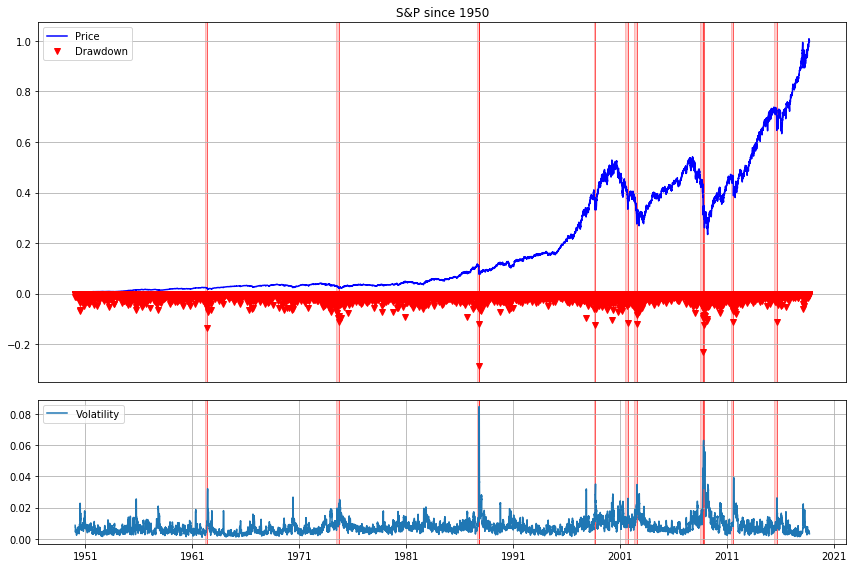

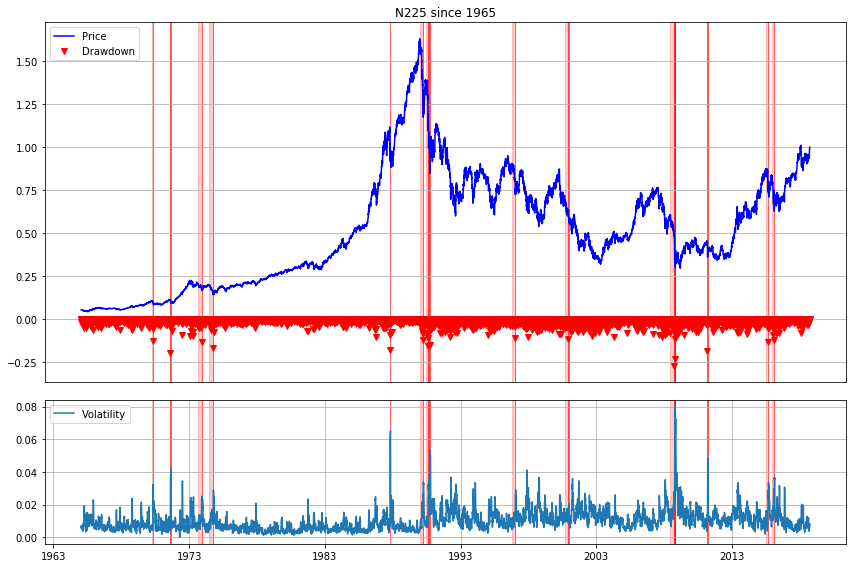

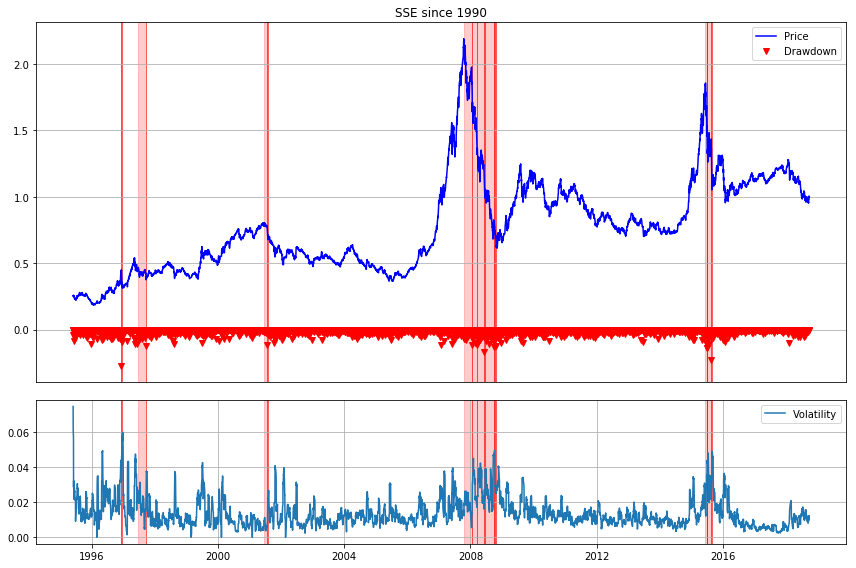

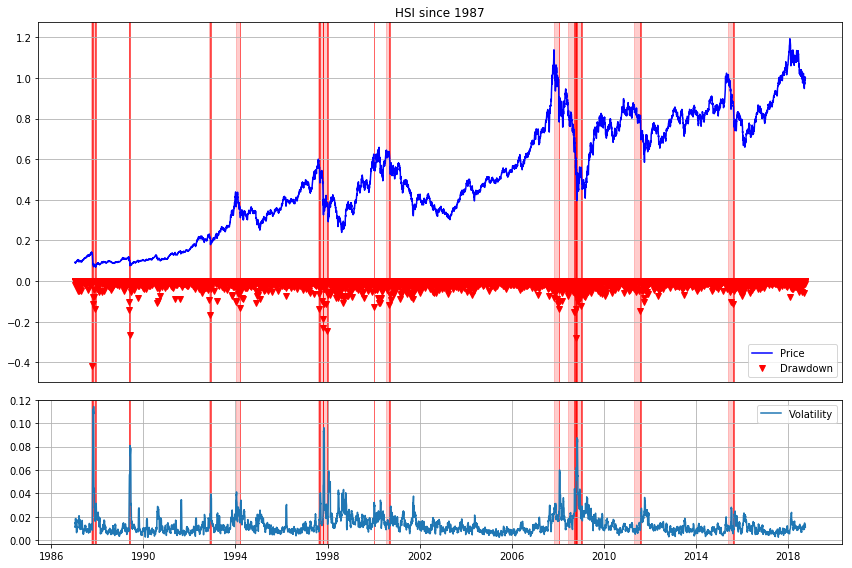

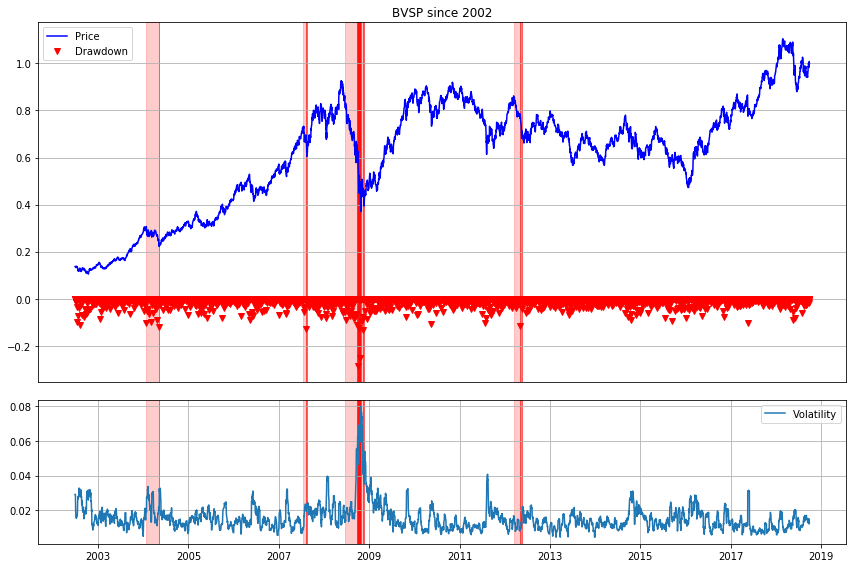

In [4]:
##### plot prices, crashes, volatility since beginning for each df
rcParams['figure.figsize'] = 12, 8
plt_titles = ['S&P since 1950', 'N225 since 1965', 'SSE since 1990', 'HSI since 1987', \
              'BVSP since 2002']
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 
for i in range(len(df_combined)):
    plt.subplot(gs[0])
    plt.plot(df_combined[i]['norm'], color='blue')
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(crashes[i]['down_st'], \
         crashes[i]['crash_st'])]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crashes[i]['crash_st'], \
         crashes[i]['crash_end'])]
    plt.plot(df_combined[i]['drawdown'], color='red', marker='v',linestyle='')
    plt.title(plt_titles[i])
    plt.grid()
    plt.xticks([])
    plt.legend(['Price', 'Drawdown'])
    plt.subplot(gs[1])
    plt.plot(df_combined[i]['vol'])
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(crashes[i]['down_st'], \
         crashes[i]['crash_st'])]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crashes[i]['crash_st'], \
         crashes[i]['crash_end'])]
    plt.legend(['Volatility'])
    plt.grid()
    plt.tight_layout()
    plt.show()

In [5]:
##### Prepare features for prediction models
##### 504 features - daily price change and volatility for 1 year
dfs_xy = []
for df, c in zip(df_combined, crashes):
    xy = {}
    #for date in df.index[255:-126]: # <--subtract 126 days in the end
    for i in range(252, df.shape[0]-126):
        date = df.index[i]
        x_ch = [df['ch'].iloc[i-j] for j in range(252)]
        x_vol = [df['vol'].iloc[i-j] for j in range(252)]
        xy[date] = x_ch + x_vol
        xy[date].append(max([date <= c and date+timedelta(3*21) > c for c in c['crash_st']]))
    df_xy = pd.DataFrame.from_dict(xy, orient='index').dropna()
    dfs_xy.append(df_xy)
    
# create two training and test sets for each df:
np_xy = np.concatenate(([np.array(xy) for xy in dfs_xy]))
split = [0]
i = 0
for df in dfs_xy:
    i += df.shape[0]-1
    split.append(i)
np_train = [] 
np_test = [] 
n = 12 * 252  # <-- 12 years test data
for j in range(len(dfs_xy) * 2):
    i = round(j/2 + 0.1)
    if j % 2 == 0:
        np_test.append(np_xy[split[i]:split[i]+n, :])
        np_train.append(np.concatenate(([np_xy[0:split[i],:], np_xy[split[i]+n:,:]])))
    if j % 2 == 1:
        np_test.append(np_xy[split[i]-n:split[i], :])
        np_train.append(np.concatenate(([np_xy[0:split[i]-n,:], np_xy[split[i]:,:]])))

In [15]:
########################### Linear regression ########################### 
# define, train and test model:
model_name = 'Linear Regression'
lm = linear_model.LinearRegression()
pct_pos = 0.1   #<- tune: increase leads to higher recall, less precision
precision_tr = []
recall_tr = []
accuracy_tr = []
precision_t = []
recall_t = []
accuracy_t = []
y_pred_bin_t_all = []  #<- store all test predictions here
y_pred_bin_tr_all = []
y_actual = []
y_tr_actual = []
for train, test in zip(np_train, np_test):
    x_tr = train[:, 0:-1]
    y_tr = train[:, -1].astype(int)  #<- crash as response variable
    y_tr_actual.append(y_tr)
    x_t = test[:, 0:-1]
    y_t = test[:, -1].astype(int)
    y_actual.append(y_t)
    model = lm.fit(x_tr, y_tr)
    y_pred_tr = model.predict(x_tr)
    y_pred_bin_tr = y_pred_tr > np.percentile(y_pred_tr, 100 * (1-pct_pos))
    y_pred_bin_tr = y_pred_bin_tr.astype(int)
    y_pred_bin_tr_all.append(y_pred_bin_tr)
    precision_tr.append(metrics.precision_score(y_tr, y_pred_bin_tr))
    recall_tr.append(metrics.recall_score(y_tr, y_pred_bin_tr))
    accuracy_tr.append(metrics.accuracy_score(y_tr, y_pred_bin_tr))
    y_pred_t = model.predict(x_t)
    y_pred_bin_t = y_pred_t > np.percentile(y_pred_t, 100 * (1-pct_pos))
    y_pred_bin_t = y_pred_bin_t.astype(int)
    y_pred_bin_t_all.append(y_pred_bin_t)  #<- list of test predictions for plots
    precision_t.append(metrics.precision_score(y_t, y_pred_bin_t))
    recall_t.append(metrics.recall_score(y_t, y_pred_bin_t))
    accuracy_t.append(metrics.accuracy_score(y_t, y_pred_bin_t))
# score: square of loss, multiplied by wtd over precision, recall, accuracy
avg_pr_tr = sum(precision_tr)/len(precision_tr)
avg_re_tr = sum(recall_tr)/len(recall_tr)
avg_ac_tr = sum(accuracy_tr)/len(accuracy_tr)
avg_pr_t = sum(precision_t)/len(precision_t)
avg_re_t = sum(recall_t)/len(recall_t)
avg_ac_t = sum(accuracy_t)/len(accuracy_t)

# calculate precision, recall, accuracy for comparable random model
rnd_y_tr_pos = sum(sum(y_pred_bin_tr_all)) / (len(y_pred_bin_tr_all[0])*len(y_pred_bin_tr_all))
y_tr_pos = sum(sum(y_tr_actual)) / (len(y_tr_actual[0])*len(y_tr_actual))
rnd_TP = rnd_y_tr_pos * y_tr_pos
rnd_FP = rnd_y_tr_pos * (1 - y_tr_pos)
rnd_TN = (1-rnd_y_tr_pos) * (1 - y_tr_pos)
rnd_FN = (1-rnd_y_tr_pos) * y_tr_pos
rnd_pr_tr = rnd_TP / (rnd_TP+rnd_FP)
rnd_re_tr = rnd_TP / (rnd_TP+rnd_FN)
rnd_ac_tr = rnd_TP + rnd_TN
rnd_y_t_pos = sum(sum(y_pred_bin_t_all)) / (len(y_pred_bin_t_all[0])*len(y_pred_bin_t_all))
y_t_pos = sum(sum(y_actual)) / (len(y_actual[0])*len(y_actual))
rnd_TP = rnd_y_t_pos * y_t_pos
rnd_FP = rnd_y_t_pos * (1 - y_t_pos)
rnd_TN = (1-rnd_y_t_pos) * (1 - y_t_pos)
rnd_FN = (1-rnd_y_t_pos) * y_t_pos
rnd_pr_t = rnd_TP / (rnd_TP+rnd_FP)
rnd_re_t = rnd_TP / (rnd_TP+rnd_FN)
rnd_ac_t = rnd_TP + rnd_TN

# score: square of loss, multiplied by wtd over precision, recall, accuracy
wtd_pr = 0.325
wtd_re = 0.375
wtd_ac = 0.3
pr_tr = (avg_pr_tr - rnd_pr_tr) / (1 - rnd_pr_tr)
re_tr = (avg_re_tr - rnd_re_tr) / (1 - rnd_re_tr)
ac_tr = (avg_ac_tr - rnd_ac_tr) / (1 - rnd_ac_tr)
score_tr = (1-(wtd_pr*(1-pr_tr)**2+wtd_re*(1-re_tr)**2+wtd_ac*(1-ac_tr)**2))*100
pr_t = (avg_pr_t - rnd_pr_t) / (1 - rnd_pr_t)
re_t = (avg_re_t - rnd_re_t) / (1 - rnd_re_t)
ac_t = (avg_ac_t - rnd_ac_t) / (1 - rnd_ac_t)
score_t = (1-(wtd_pr*(1-pr_t)**2+wtd_re*(1-re_t)**2+wtd_ac*(1-ac_t)**2))*100
print('Results ' + model_name + ':')
print('Number of features: ' + str(dfs_xy[0].shape[1]-1) + '; number of rows: ' \
      + str(np_xy.shape[0]))
print('Avg precision train (model/random): '+ str(round(avg_pr_tr, 2))+' / '+str(round(rnd_pr_tr, 2)))
print('Avg recall train (model/random):    '+ str(round(avg_re_tr, 2))+' / '+str(round(rnd_re_tr, 2)))
print('Avg accuracy train (model/random):  '+ str(round(avg_ac_tr, 2))+' / '+str(round(rnd_ac_tr, 2)))
print('Score train:                        '+ str(round(score_tr)))
print('Avg precision test (model/random):  '+ str(round(avg_pr_t, 2))+' / '+str(round(rnd_pr_t, 2)))
print('Avg recall test (model/random):     '+ str(round(avg_re_t, 2))+' / '+str(round(rnd_re_t, 2)))
print('Avg accuracy test (model/random):   '+ str(round(avg_ac_t, 2))+' / '+str(round(rnd_ac_t, 2)))
print('Score test:                         '+ str(round(score_t)))

Results Linear Regression:
Number of features: 504; number of rows: 46327
Avg precision train (model/random): 0.19 / 0.05
Avg recall train (model/random):    0.4 / 0.1
Avg accuracy train (model/random):  0.89 / 0.86
Score train:                        41.0
Avg precision test (model/random):  0.22 / 0.06
Avg recall test (model/random):     0.31 / 0.1
Avg accuracy test (model/random):   0.88 / 0.85
Score test:                         36.0


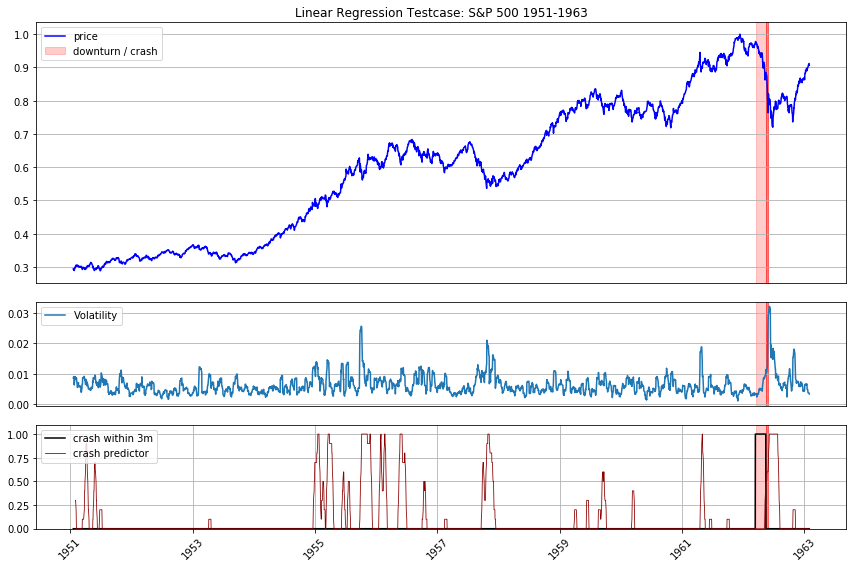

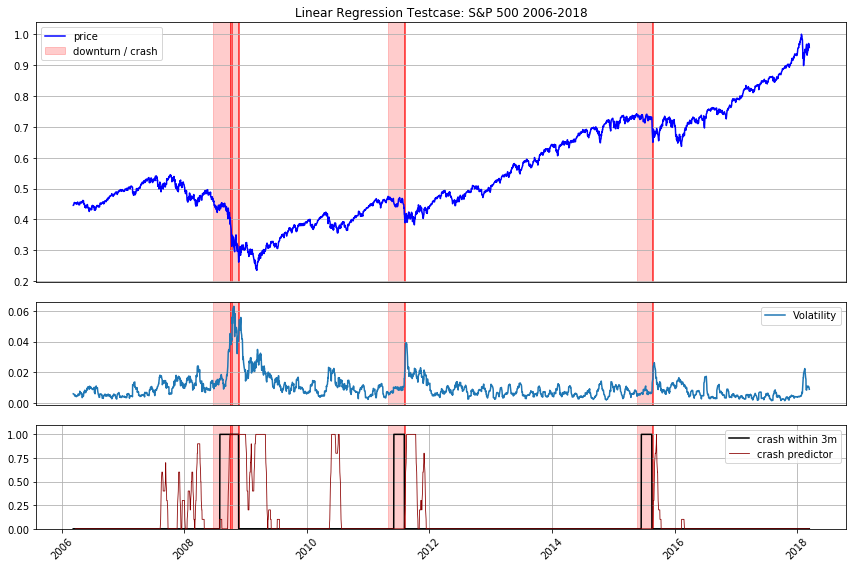

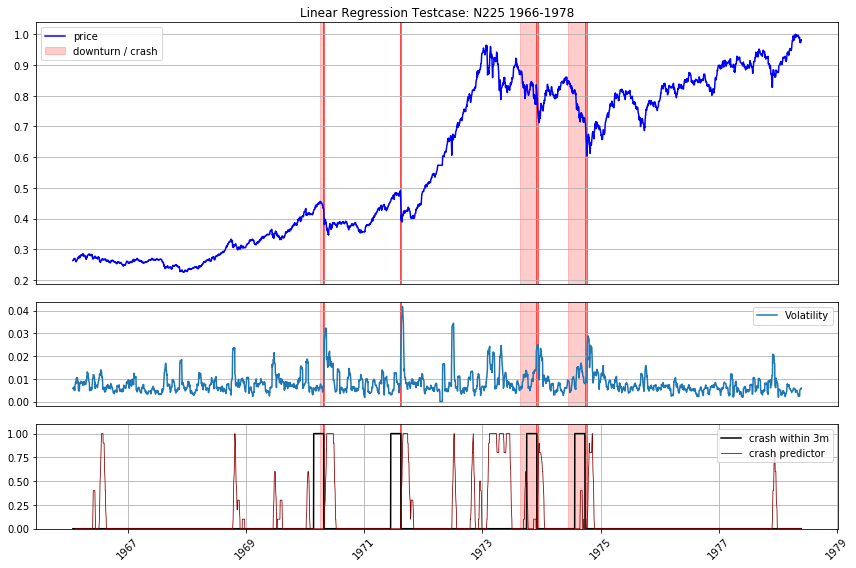

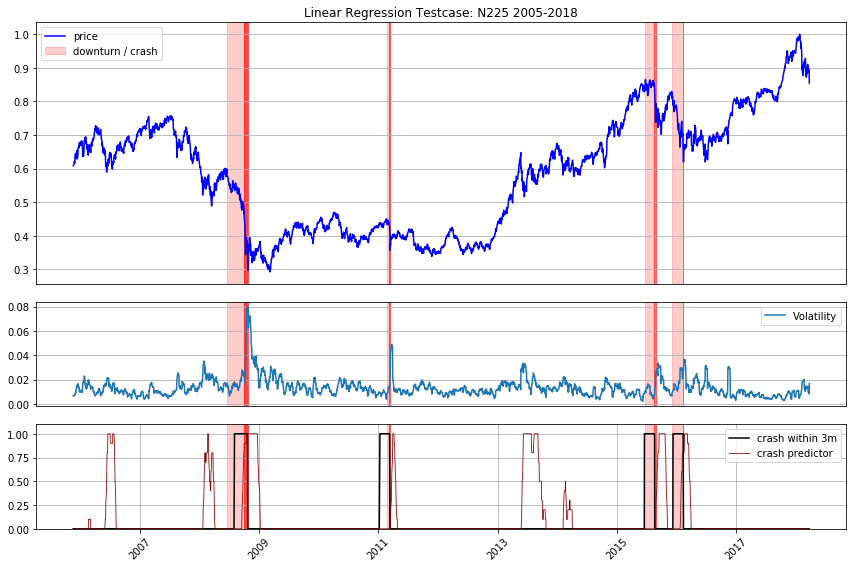

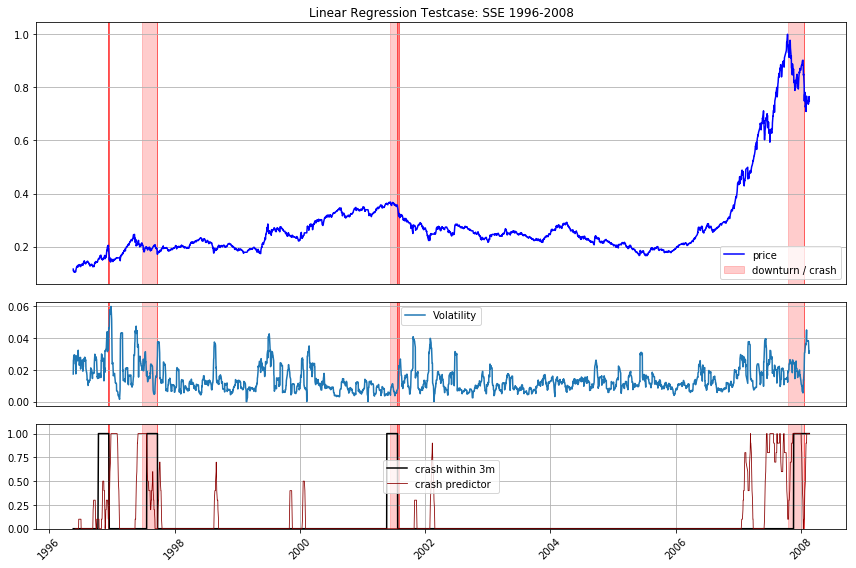

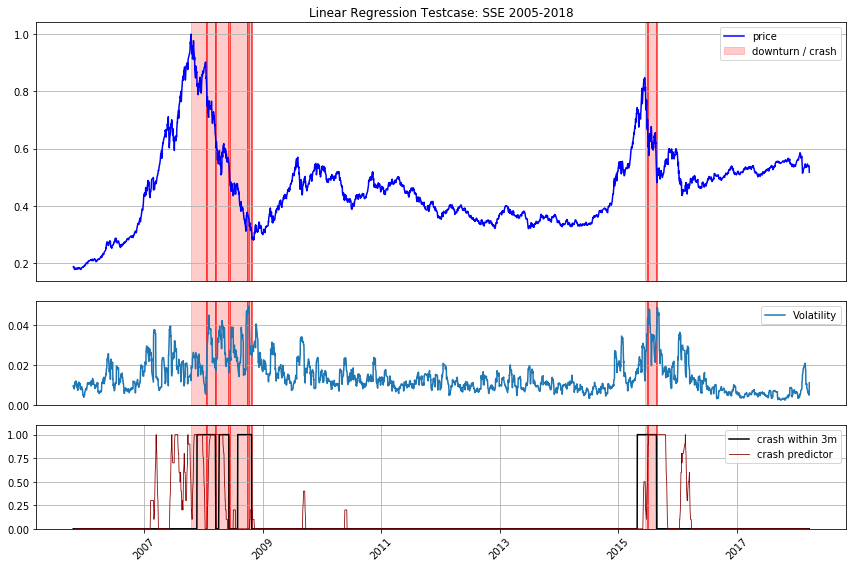

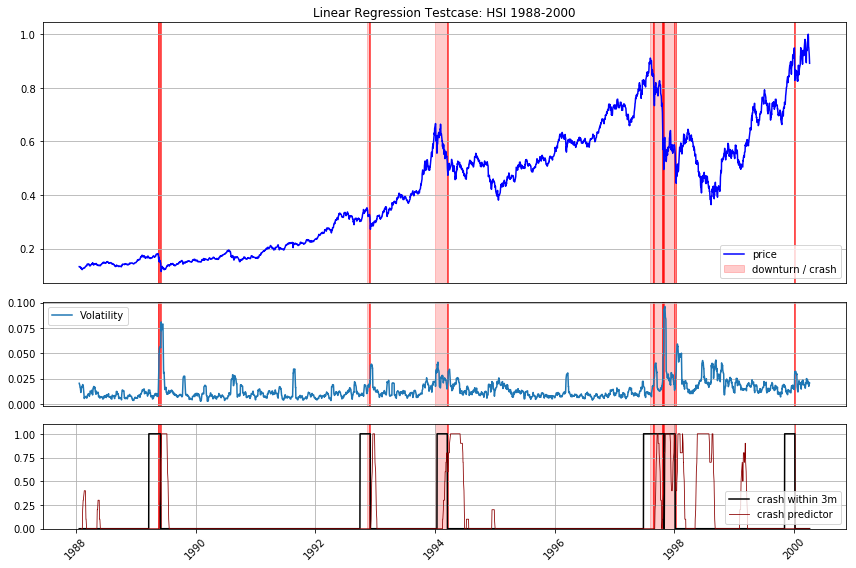

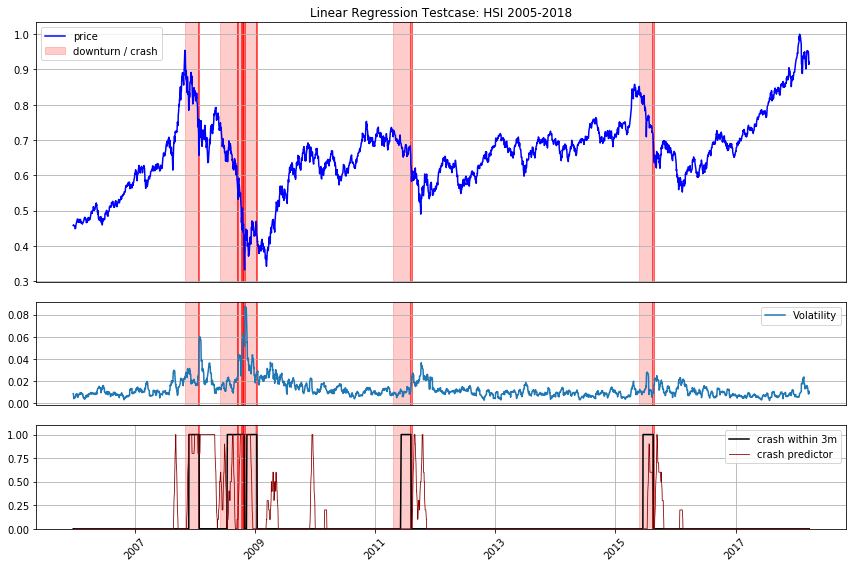

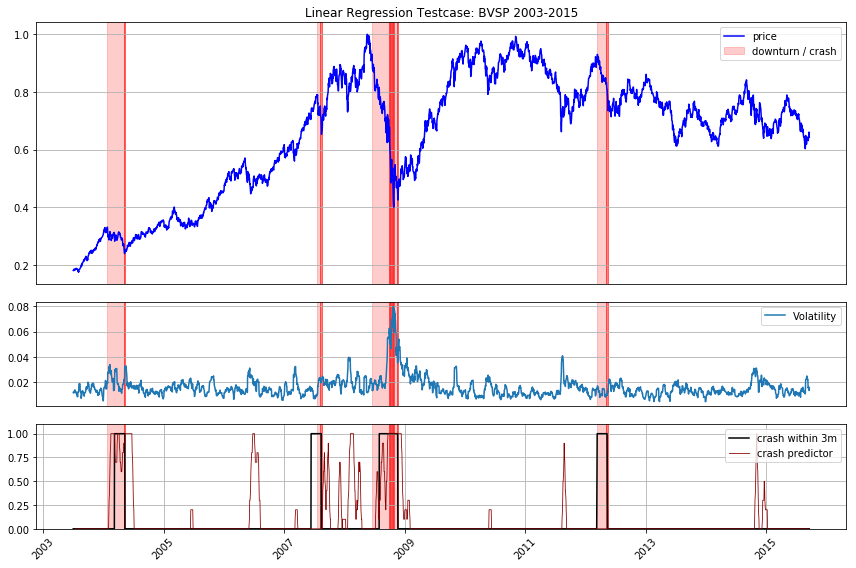

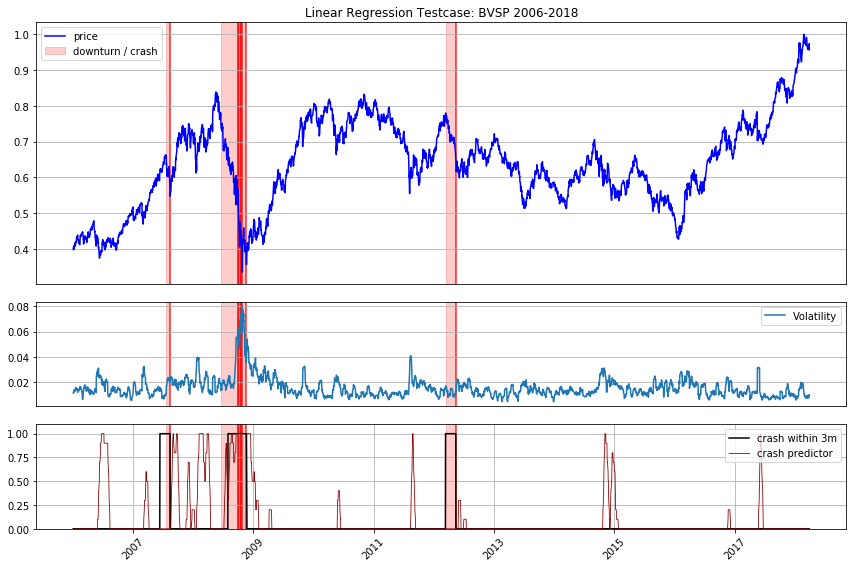

In [16]:
##### Linear Regression - plots for all test cases:
df_combined = [dfc.reindex(dfs.index) for dfc, dfs in zip(df_combined, dfs_xy)]
dfs_predict = []
for j in range(len(datasets)*2):
    i = round(j/2 + 0.1)
    k = round(j/2 - 0.1)
    if j % 2 == 0:
        df = df_combined[k].iloc[:n, :]
        df['y_pred'] = y_pred_bin_t_all[j]
        df['y'] = y_actual[j]
        dfs_predict.append(df)
    if j % 2 == 1:       
        df = df_combined[k].iloc[-n:, :]
        df['y_pred'] = y_pred_bin_t_all[j]
        df['y'] = y_actual[j]
        dfs_predict.append(df)
cr_ext = []
for c in crashes:
    cr_ext.append(c)
    cr_ext.append(c)
ds_name_ext = []
for ds_name in dataset_names:
    ds_name_ext.append(ds_name)
    ds_name_ext.append(ds_name)    
gs = gridspec.GridSpec(3, 1, height_ratios=[2.5, 1, 1]) 
for df, c, t in zip(dfs_predict, cr_ext, ds_name_ext):
    t1 = df.index[0]
    t2 = df.index[-1]
    plt.subplot(gs[0])
    down_st = list(filter(lambda x: x > t1 and x < t2, c['down_st']))
    crash_st = list(filter(lambda x: x > t1 and x < t2, c['crash_st']))
    crash_end = list(filter(lambda x: x > t1 and x < t2, c['crash_end']))
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    df_norm = df['price'][t1:t2] / df['price'][t1:t2].max()
    plt.plot(df_norm[t1:t2], color='blue') 
    plt.title(model_name + ' Testcase: ' + t + ' ' + str(df.index[0].year) + '-' \
              + str(df.index[-1].year))
    plt.legend(['price', 'downturn / crash'])
    plt.xticks([])
    plt.grid()     
    plt.subplot(gs[1])
    plt.plot(df.loc[t1:t2, 'vol'])
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['Volatility'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.xticks([])
    plt.subplot(gs[2])
    plt.plot(df['y'][t1:t2], color='black')
    plt.plot(df['y_pred'][t1:t2].rolling(10).mean(), color='darkred', linewidth=0.8)
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['crash within 3m', 'crash predictor'])
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.show()  

In [17]:
########################### Logistic Regression ########################### 
# define, train and test model:
model_name = 'Logistic Regression'
#clf = linear_model.LogisticRegression(C=1, class_weight='balanced')
clf = linear_model.LogisticRegression(C=1, class_weight={0:.075, 1:.925})
#clf = linear_model.LogisticRegression(C=10, class_weight={0:.05, 1:.95})
precision_tr = []
recall_tr = []
accuracy_tr = []
precision_t = []
recall_t = []
accuracy_t = []
y_pred_bin_t_all = []  #<- store all test predictions here
y_pred_bin_tr_all = []
y_actual = []
y_tr_actual = []
for train, test in zip(np_train, np_test):
    x_tr = train[:, 0:-1]
    y_tr = train[:, -1].astype(int)  #<- crash as response variable
    y_tr_actual.append(y_tr)
    x_t = test[:, 0:-1]
    y_t = test[:, -1].astype(int)
    y_actual.append(y_t)
    model = clf.fit(x_tr, y_tr)
    y_pred_bin_tr = model.predict(x_tr)
    y_pred_bin_tr_all.append(y_pred_bin_tr) 
    precision_tr.append(metrics.precision_score(y_tr, y_pred_bin_tr))
    recall_tr.append(metrics.recall_score(y_tr, y_pred_bin_tr))
    accuracy_tr.append(metrics.accuracy_score(y_tr, y_pred_bin_tr))
    y_pred_bin_t = model.predict(x_t)
    y_pred_bin_t_all.append(y_pred_bin_t)  #<- list of test predictions for plots
    precision_t.append(metrics.precision_score(y_t, y_pred_bin_t))
    recall_t.append(metrics.recall_score(y_t, y_pred_bin_t))
    accuracy_t.append(metrics.accuracy_score(y_t, y_pred_bin_t))

avg_pr_tr = sum(precision_tr) / len(precision_tr)
avg_re_tr = sum(recall_tr) / len(recall_tr)
avg_ac_tr = sum(accuracy_tr) / len(accuracy_tr)
avg_pr_t = sum(precision_t) / len(precision_t)
avg_re_t = sum(recall_t) / len(recall_t)
avg_ac_t = sum(accuracy_t) / len(accuracy_t)

# calculate precision, recall, accuracy for comparable random model
rnd_y_tr_pos = sum(sum(y_pred_bin_tr_all)) / (len(y_pred_bin_tr_all[0])*len(y_pred_bin_tr_all))
y_tr_pos = sum(sum(y_tr_actual)) / (len(y_tr_actual[0])*len(y_tr_actual))
rnd_TP = rnd_y_tr_pos * y_tr_pos
rnd_FP = rnd_y_tr_pos * (1 - y_tr_pos)
rnd_TN = (1-rnd_y_tr_pos) * (1 - y_tr_pos)
rnd_FN = (1-rnd_y_tr_pos) * y_tr_pos
rnd_pr_tr = rnd_TP / (rnd_TP+rnd_FP)
rnd_re_tr = rnd_TP / (rnd_TP+rnd_FN)
rnd_ac_tr = rnd_TP + rnd_TN
rnd_y_t_pos = sum(sum(y_pred_bin_t_all)) / (len(y_pred_bin_t_all[0])*len(y_pred_bin_t_all))
y_t_pos = sum(sum(y_actual)) / (len(y_actual[0])*len(y_actual))
rnd_TP = rnd_y_t_pos * y_t_pos
rnd_FP = rnd_y_t_pos * (1 - y_t_pos)
rnd_TN = (1-rnd_y_t_pos) * (1 - y_t_pos)
rnd_FN = (1-rnd_y_t_pos) * y_t_pos
rnd_pr_t = rnd_TP / (rnd_TP+rnd_FP)
rnd_re_t = rnd_TP / (rnd_TP+rnd_FN)
rnd_ac_t = rnd_TP + rnd_TN

# score: square of loss, multiplied by wtd over precision, recall, accuracy
wtd_pr = 0.325
wtd_re = 0.375
wtd_ac = 0.3
pr_tr = (avg_pr_tr - rnd_pr_tr) / (1 - rnd_pr_tr)
re_tr = (avg_re_tr - rnd_re_tr) / (1 - rnd_re_tr)
ac_tr = (avg_ac_tr - rnd_ac_tr) / (1 - rnd_ac_tr)
score_tr = (1-(wtd_pr*(1-pr_tr)**2+wtd_re*(1-re_tr)**2+wtd_ac*(1-ac_tr)**2))*100
pr_t = (avg_pr_t - rnd_pr_t) / (1 - rnd_pr_t)
re_t = (avg_re_t - rnd_re_t) / (1 - rnd_re_t)
ac_t = (avg_ac_t - rnd_ac_t) / (1 - rnd_ac_t)
score_t = (1-(wtd_pr*(1-pr_t)**2+wtd_re*(1-re_t)**2+wtd_ac*(1-ac_t)**2))*100

print('Results ' + model_name + ':')
print('Number of features: ' + str(dfs_xy[0].shape[1]-1) + '; number of rows: ' \
      + str(np_xy.shape[0]))
print('Positive train cases actual:        '+ str(round(y_tr_pos, 2)))
print('Positive train cases predicted:     '+ str(round(rnd_y_tr_pos, 2)))
print('Avg precision train (model/random): '+ str(round(avg_pr_tr, 2))+' / '+str(round(rnd_pr_tr, 2)))
print('Avg recall train (model/random):    '+ str(round(avg_re_tr, 2))+' / '+str(round(rnd_re_tr, 2)))
print('Avg accuracy train (model/random):  '+ str(round(avg_ac_tr, 2))+' / '+str(round(rnd_ac_tr, 2)))
print('Score train:                        '+ str(round(score_tr)))
print('Positive test cases actual:         '+ str(round(y_t_pos, 2)))
print('Positive test cases predicted:      '+ str(round(rnd_y_t_pos, 2)))
print('Avg precision test (model/random):  '+ str(round(avg_pr_t, 2))+' / '+str(round(rnd_pr_t, 2)))
print('Avg recall test (model/random):     '+ str(round(avg_re_t, 2))+' / '+str(round(rnd_re_t, 2)))
print('Avg accuracy test (model/random):   '+ str(round(avg_ac_t, 2))+' / '+str(round(rnd_ac_t, 2)))
print('Score test:                         '+ str(round(score_t)))

Results Logistic Regression:
Number of features: 504; number of rows: 46327
Positive train cases actual:        0.05
Positive train cases predicted:     0.08
Avg precision train (model/random): 0.21 / 0.05
Avg recall train (model/random):    0.35 / 0.08
Avg accuracy train (model/random):  0.91 / 0.88
Score train:                        40.0
Positive test cases actual:         0.06
Positive test cases predicted:      0.14
Avg precision test (model/random):  0.16 / 0.06
Avg recall test (model/random):     0.38 / 0.14
Avg accuracy test (model/random):   0.85 / 0.81
Score test:                         36.0


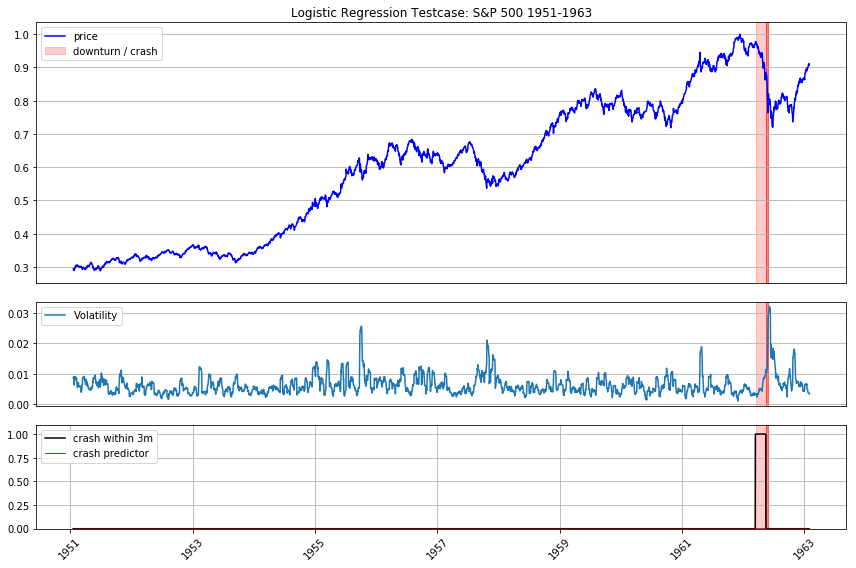

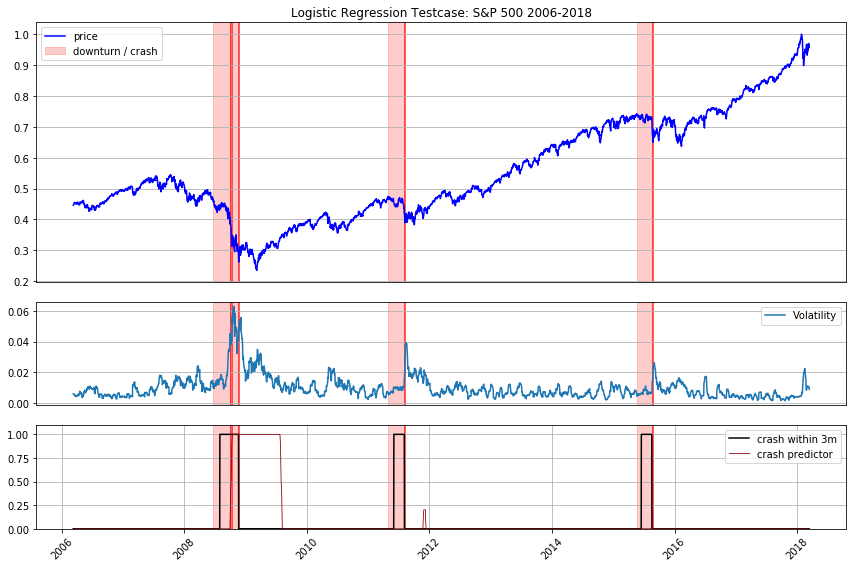

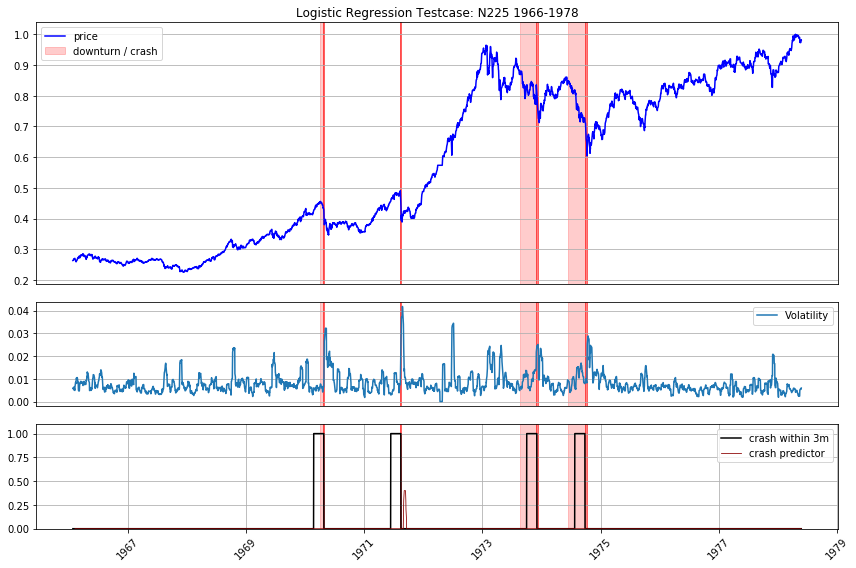

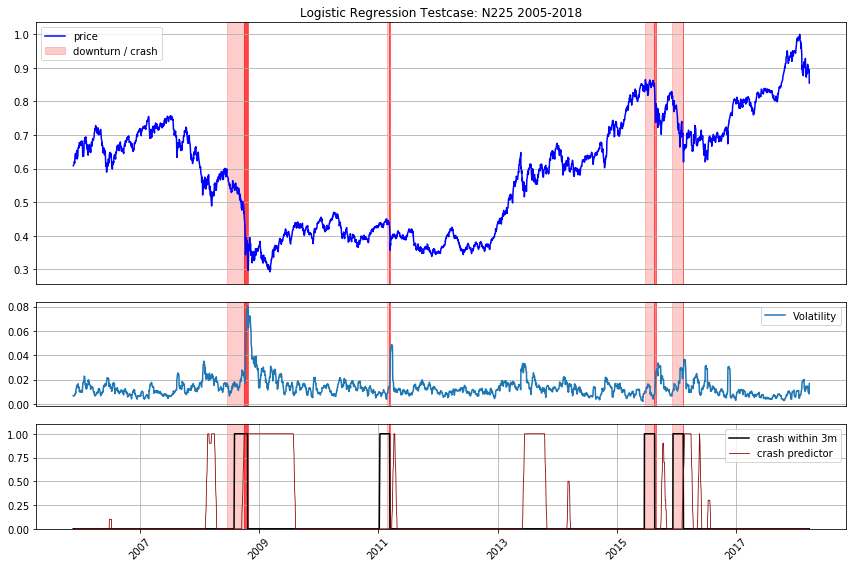

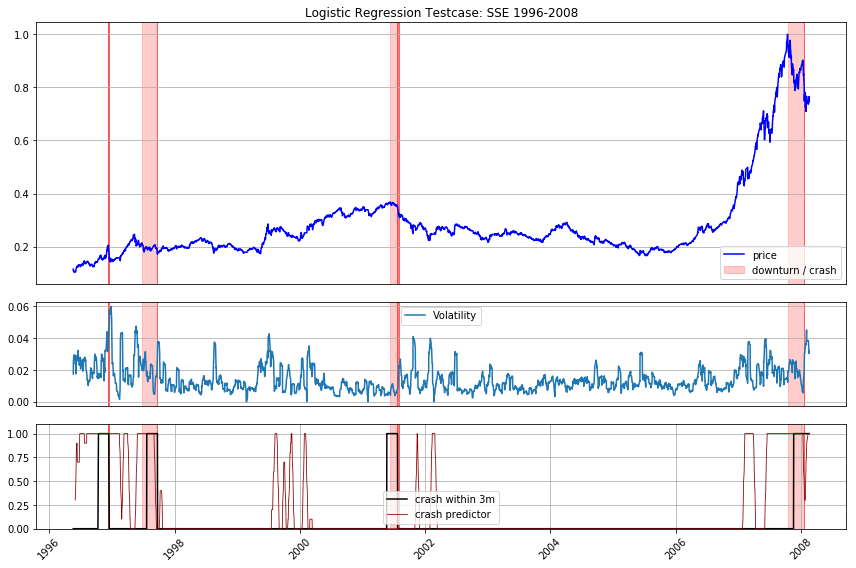

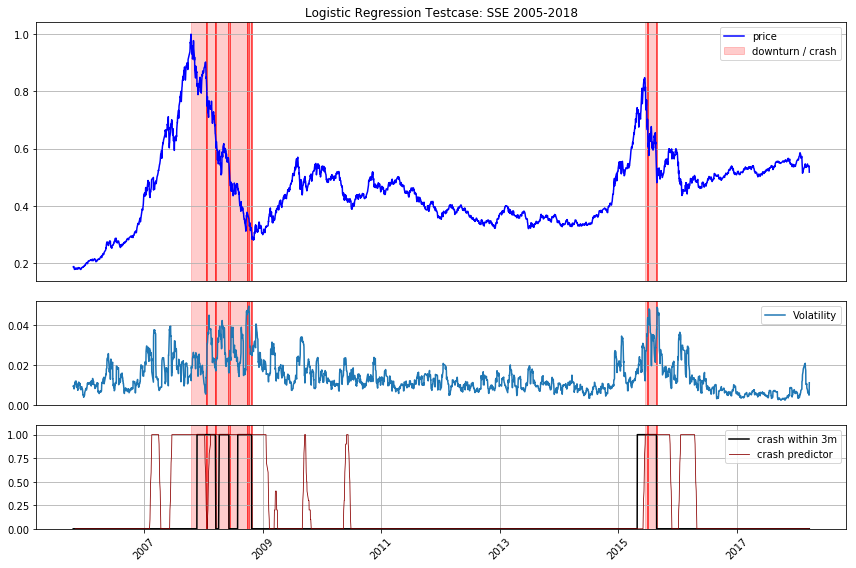

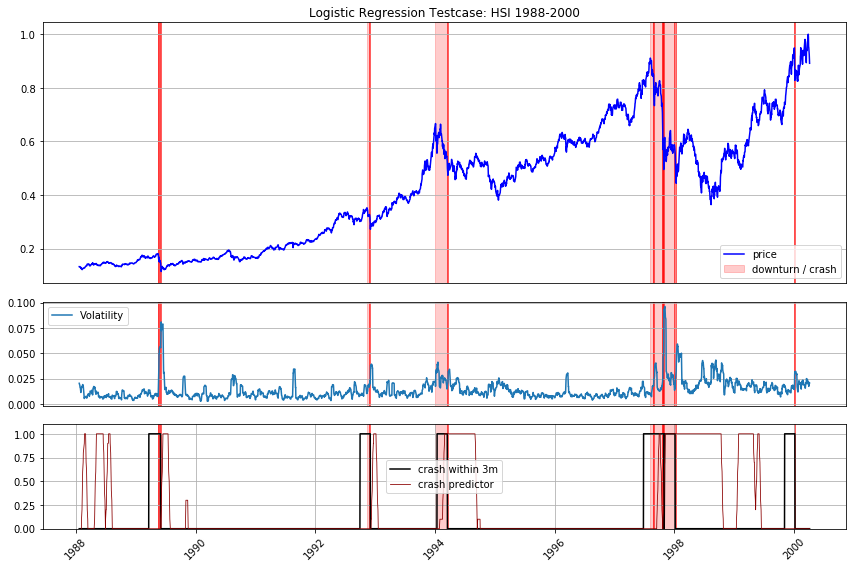

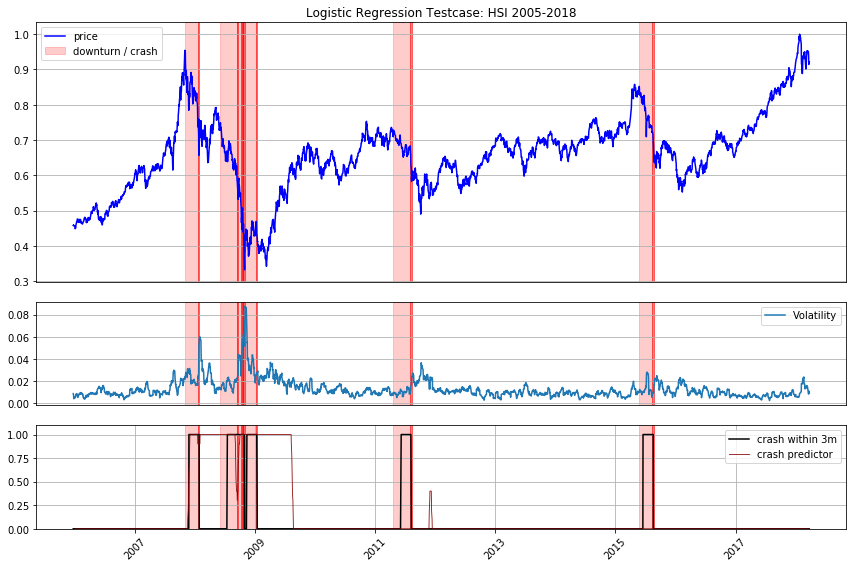

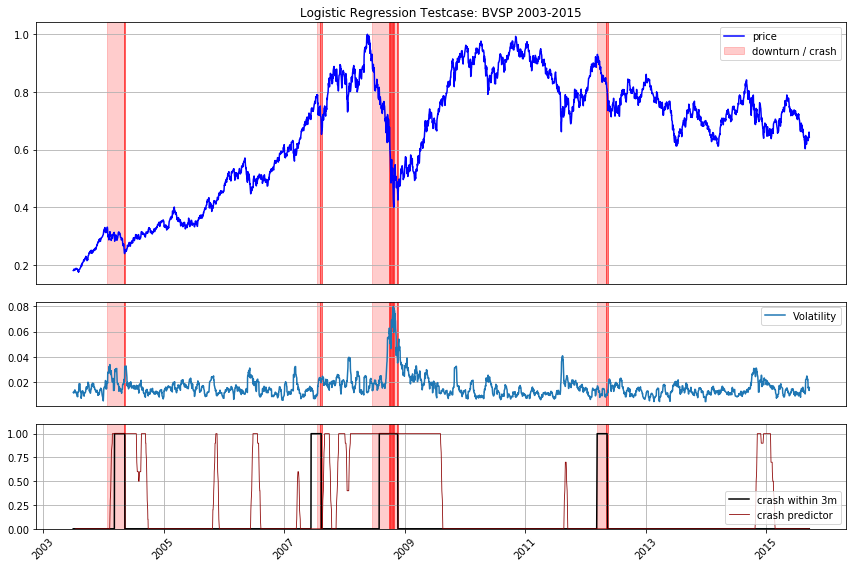

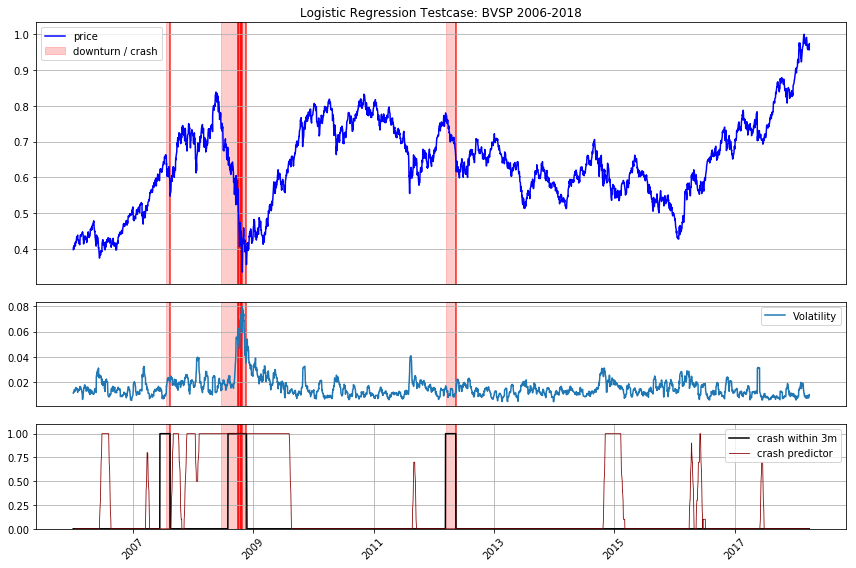

In [18]:
##### Logistic Regression - plots for all test cases:
df_combined = [dfc.reindex(dfs.index) for dfc, dfs in zip(df_combined, dfs_xy)]
dfs_predict = []
for j in range(len(datasets)*2):
    i = round(j/2 + 0.1)
    k = round(j/2 - 0.1)
    if j % 2 == 0:
        df = df_combined[k].iloc[:n, :]
        df['y_pred'] = y_pred_bin_t_all[j]
        df['y'] = y_actual[j]
        dfs_predict.append(df)
    if j % 2 == 1:       
        df = df_combined[k].iloc[-n:, :]
        df['y_pred'] = y_pred_bin_t_all[j]
        df['y'] = y_actual[j]
        dfs_predict.append(df)
cr_ext = []
for c in crashes:
    cr_ext.append(c)
    cr_ext.append(c)
ds_name_ext = []
for ds_name in dataset_names:
    ds_name_ext.append(ds_name)
    ds_name_ext.append(ds_name)    
gs = gridspec.GridSpec(3, 1, height_ratios=[2.5, 1, 1]) 
for df, c, t in zip(dfs_predict, cr_ext, ds_name_ext):
    t1 = df.index[0]
    t2 = df.index[-1]
    plt.subplot(gs[0])
    down_st = list(filter(lambda x: x > t1 and x < t2, c['down_st']))
    crash_st = list(filter(lambda x: x > t1 and x < t2, c['crash_st']))
    crash_end = list(filter(lambda x: x > t1 and x < t2, c['crash_end']))
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    df_norm = df['price'][t1:t2] / df['price'][t1:t2].max()
    plt.plot(df_norm[t1:t2], color='blue') 
    plt.title(model_name + ' Testcase: ' + t + ' ' + str(df.index[0].year) + '-' \
              + str(df.index[-1].year))
    plt.legend(['price', 'downturn / crash'])
    plt.xticks([])
    plt.grid()     
    plt.subplot(gs[1])
    plt.plot(df.loc[t1:t2, 'vol'])
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['Volatility'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.xticks([])
    plt.subplot(gs[2])
    plt.plot(df['y'][t1:t2], color='black')
    plt.plot(df['y_pred'][t1:t2].rolling(10).mean(), color='darkred', linewidth=0.8)
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['crash within 3m', 'crash predictor'])
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.show()  

In [10]:
########################### SVM Classifier linear ########################### 
# define, train and test model:
model_name = 'SVM: Linear Classification'
clf = svm.SVC(C=1, kernel='linear', class_weight='balanced')#'rbf: radial basis function

precision_tr = []
recall_tr = []
accuracy_tr = []
precision_t = []
recall_t = []
accuracy_t = []
y_pred_bin_t_all = []  #<- store all test predictions here
y_pred_bin_tr_all = []
y_actual = []
y_tr_actual = []
for train, test in zip(np_train, np_test):
    x_tr = train[:, 0:-1]
    y_tr = train[:, -1].astype(int)  #<- crash as response variable
    y_tr_actual.append(y_tr)
    x_t = test[:, 0:-1]
    y_t = test[:, -1].astype(int)
    y_actual.append(y_t)
    model = clf.fit(x_tr, y_tr)
    y_pred_bin_tr = model.predict(x_tr)
    y_pred_bin_tr_all.append(y_pred_bin_tr) 
    precision_tr.append(metrics.precision_score(y_tr, y_pred_bin_tr))
    recall_tr.append(metrics.recall_score(y_tr, y_pred_bin_tr))
    accuracy_tr.append(metrics.accuracy_score(y_tr, y_pred_bin_tr))
    y_pred_bin_t = model.predict(x_t)
    y_pred_bin_t_all.append(y_pred_bin_t)  #<- list of test predictions for plots
    precision_t.append(metrics.precision_score(y_t, y_pred_bin_t))
    recall_t.append(metrics.recall_score(y_t, y_pred_bin_t))
    accuracy_t.append(metrics.accuracy_score(y_t, y_pred_bin_t))

avg_pr_tr = sum(precision_tr) / len(precision_tr)
avg_re_tr = sum(recall_tr) / len(recall_tr)
avg_ac_tr = sum(accuracy_tr) / len(accuracy_tr)
avg_pr_t = sum(precision_t) / len(precision_t)
avg_re_t = sum(recall_t) / len(recall_t)
avg_ac_t = sum(accuracy_t) / len(accuracy_t)

# calculate precision, recall, accuracy for comparable random model
rnd_y_tr_pos = sum(sum(y_pred_bin_tr_all)) / (len(y_pred_bin_tr_all[0])*len(y_pred_bin_tr_all))
y_tr_pos = sum(sum(y_tr_actual)) / (len(y_tr_actual[0])*len(y_tr_actual))
rnd_TP = rnd_y_tr_pos * y_tr_pos
rnd_FP = rnd_y_tr_pos * (1 - y_tr_pos)
rnd_TN = (1-rnd_y_tr_pos) * (1 - y_tr_pos)
rnd_FN = (1-rnd_y_tr_pos) * y_tr_pos
rnd_pr_tr = rnd_TP / (rnd_TP+rnd_FP)
rnd_re_tr = rnd_TP / (rnd_TP+rnd_FN)
rnd_ac_tr = rnd_TP + rnd_TN
rnd_y_t_pos = sum(sum(y_pred_bin_t_all)) / (len(y_pred_bin_t_all[0])*len(y_pred_bin_t_all))
y_t_pos = sum(sum(y_actual)) / (len(y_actual[0])*len(y_actual))
rnd_TP = rnd_y_t_pos * y_t_pos
rnd_FP = rnd_y_t_pos * (1 - y_t_pos)
rnd_TN = (1-rnd_y_t_pos) * (1 - y_t_pos)
rnd_FN = (1-rnd_y_t_pos) * y_t_pos
rnd_pr_t = rnd_TP / (rnd_TP+rnd_FP)
rnd_re_t = rnd_TP / (rnd_TP+rnd_FN)
rnd_ac_t = rnd_TP + rnd_TN

# score: square of loss, multiplied by wtd over precision, recall, accuracy
wtd_pr = 0.325
wtd_re = 0.375
wtd_ac = 0.3
pr_tr = (avg_pr_tr - rnd_pr_tr) / (1 - rnd_pr_tr)
re_tr = (avg_re_tr - rnd_re_tr) / (1 - rnd_re_tr)
ac_tr = (avg_ac_tr - rnd_ac_tr) / (1 - rnd_ac_tr)
score_tr = (1-(wtd_pr*(1-pr_tr)**2+wtd_re*(1-re_tr)**2+wtd_ac*(1-ac_tr)**2))*100
pr_t = (avg_pr_t - rnd_pr_t) / (1 - rnd_pr_t)
re_t = (avg_re_t - rnd_re_t) / (1 - rnd_re_t)
ac_t = (avg_ac_t - rnd_ac_t) / (1 - rnd_ac_t)
score_t = (1-(wtd_pr*(1-pr_t)**2+wtd_re*(1-re_t)**2+wtd_ac*(1-ac_t)**2))*100

print('Results ' + model_name + ':')
print('Number of features: ' + str(dfs_xy[0].shape[1]-1) + '; number of rows: ' \
      + str(np_xy.shape[0]))
print('Positive train cases actual:        '+ str(round(y_tr_pos, 2)))
print('Positive train cases predicted:     '+ str(round(rnd_y_tr_pos, 2)))
print('Avg precision train (model/random): '+ str(round(avg_pr_tr, 2))+' / '+str(round(rnd_pr_tr, 2)))
print('Avg recall train (model/random):    '+ str(round(avg_re_tr, 2))+' / '+str(round(rnd_re_tr, 2)))
print('Avg accuracy train (model/random):  '+ str(round(avg_ac_tr, 2))+' / '+str(round(rnd_ac_tr, 2)))
print('Score train:                        '+ str(round(score_tr)))
print('Positive test cases actual:         '+ str(round(y_t_pos, 2)))
print('Positive test cases predicted:      '+ str(round(rnd_y_t_pos, 2)))
print('Avg precision test (model/random):  '+ str(round(avg_pr_t, 2))+' / '+str(round(rnd_pr_t, 2)))
print('Avg recall test (model/random):     '+ str(round(avg_re_t, 2))+' / '+str(round(rnd_re_t, 2)))
print('Avg accuracy test (model/random):   '+ str(round(avg_ac_t, 2))+' / '+str(round(rnd_ac_t, 2)))
print('Score test:                         '+ str(round(score_t)))

Results SVM: Linear Classification:
Number of features: 504; number of rows: 46327
Positive train cases actual:        0.05
Positive train cases predicted:     0.21
Avg precision train (model/random): 0.13 / 0.05
Avg recall train (model/random):    0.6 / 0.21
Avg accuracy train (model/random):  0.8 / 0.76
Score train:                        42.0
Positive test cases actual:         0.06
Positive test cases predicted:      0.29
Avg precision test (model/random):  0.11 / 0.06
Avg recall test (model/random):     0.54 / 0.29
Avg accuracy test (model/random):   0.72 / 0.68
Score test:                         32.0


In [11]:
##### save results:
keys_y_test_act =['y_test_actual1', 'y_test_actual2', 'y_test_actual3', 'y_test_actual4', \
       'y_test_actual5', 'y_test_actual6']
keys_y_test_pred =['y_test_pred1', 'y_test_pred2', 'y_test_pred3', 'y_test_pred4', \
       'y_test_pred5', 'y_test_pred6']
keys_y_train_act =['y_train_actual1', 'y_train_actual2', 'y_train_actual3', 'y_train_actual4', \
       'y_train_actual5', 'y_train_actual6']
keys_y_train_pred =['y_train_pred1', 'y_train_pred2', 'y_train_pred3', 'y_train_pred4', \
       'y_train_pred5', 'y_train_pred6']
y1 = pd.DataFrame({ k:v for (k,v) in zip(keys_y_test_act, y_actual)})
y2 = pd.DataFrame({ k:v for (k,v) in zip(keys_y_test_pred, y_pred_bin_t_all)})
y3 = pd.DataFrame({ k:v for (k,v) in zip(keys_y_train_act, y_tr_actual)})
y4 = pd.DataFrame({ k:v for (k,v) in zip(keys_y_train_pred, y_pred_bin_tr_all)}) 
df_SVCLin_504_3m = pd.concat([y1, y2, y3, y4], axis=1)
df_SVCLin_504_3m.to_csv('results_SVCLin_504_3m.csv', index=False)

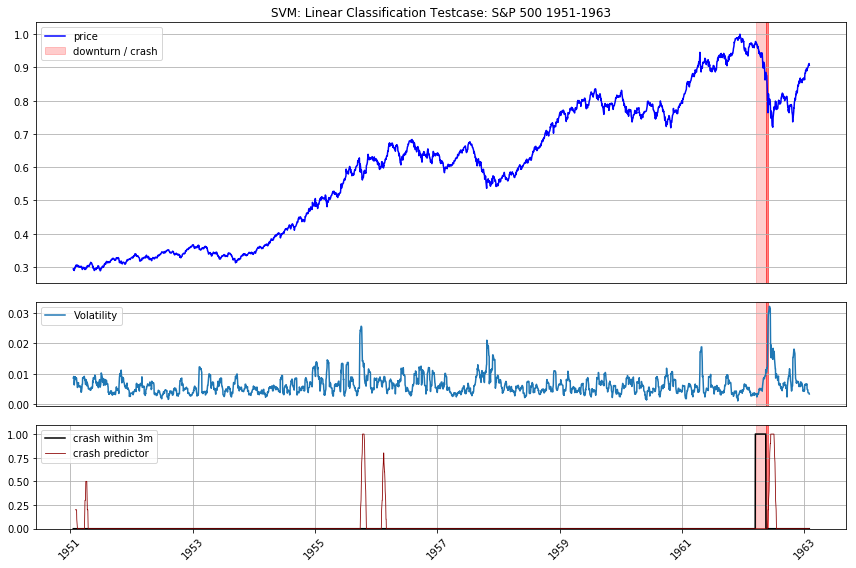

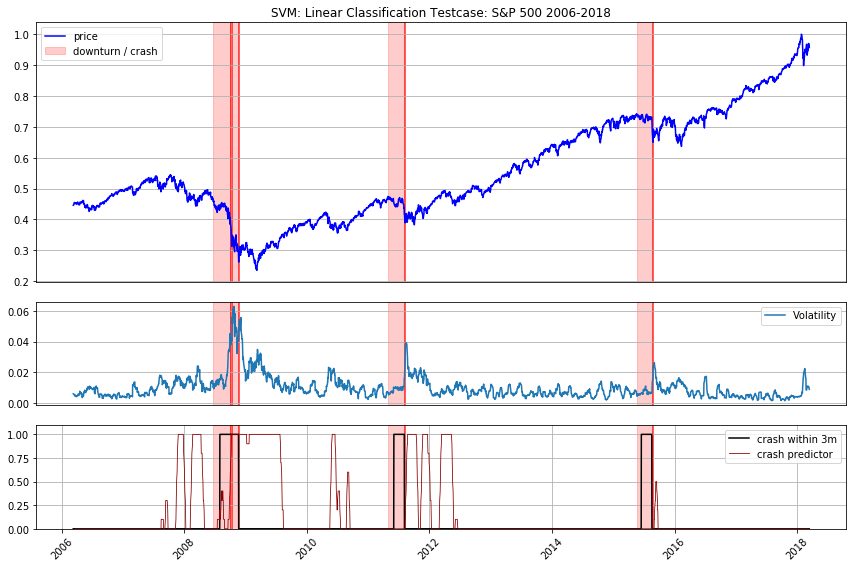

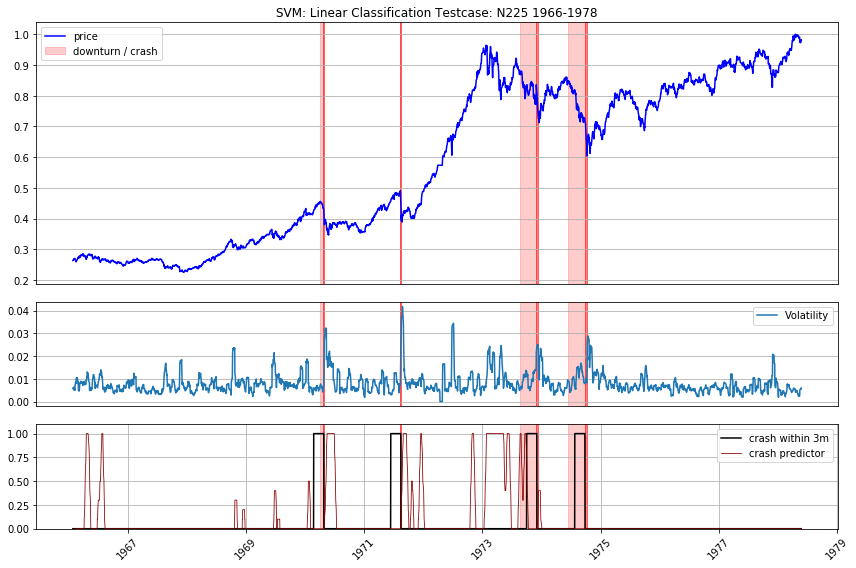

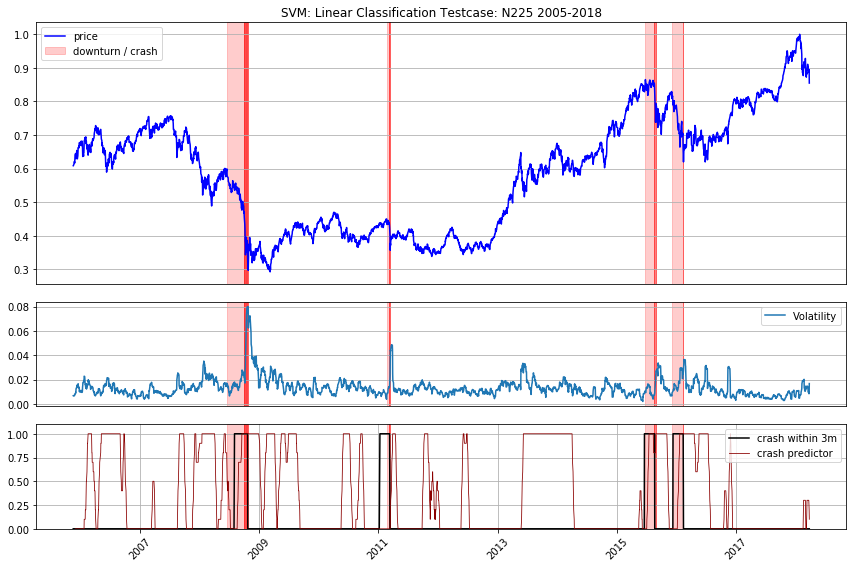

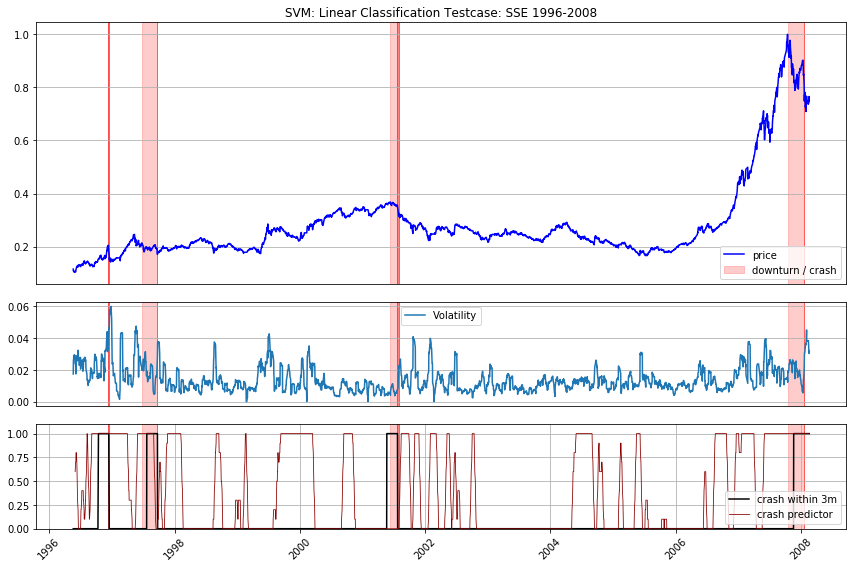

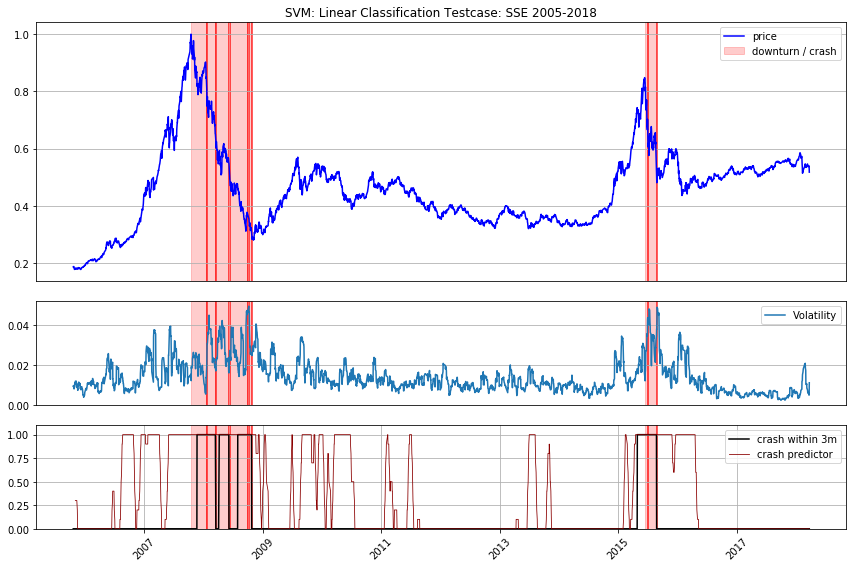

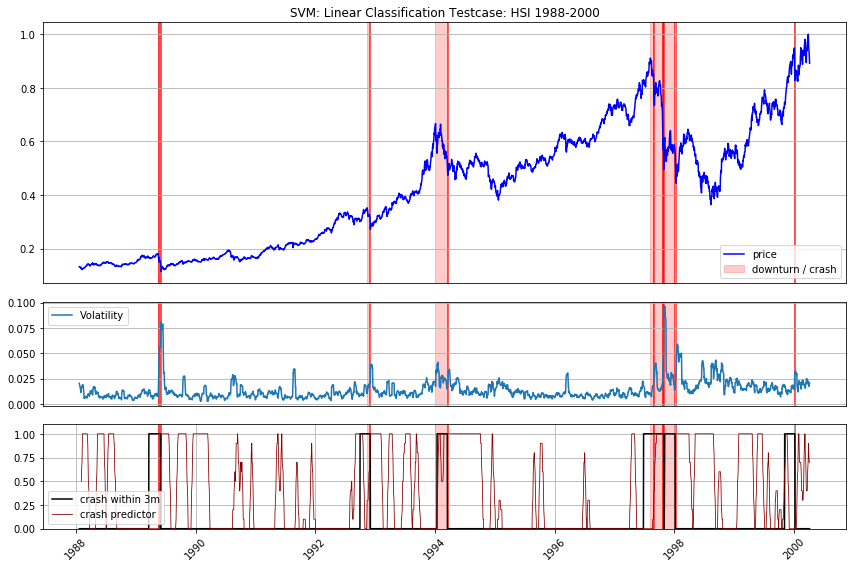

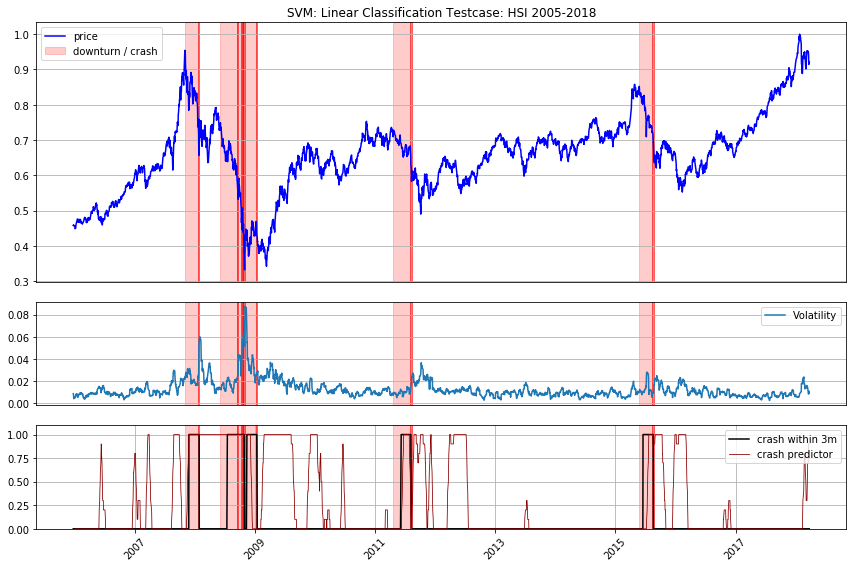

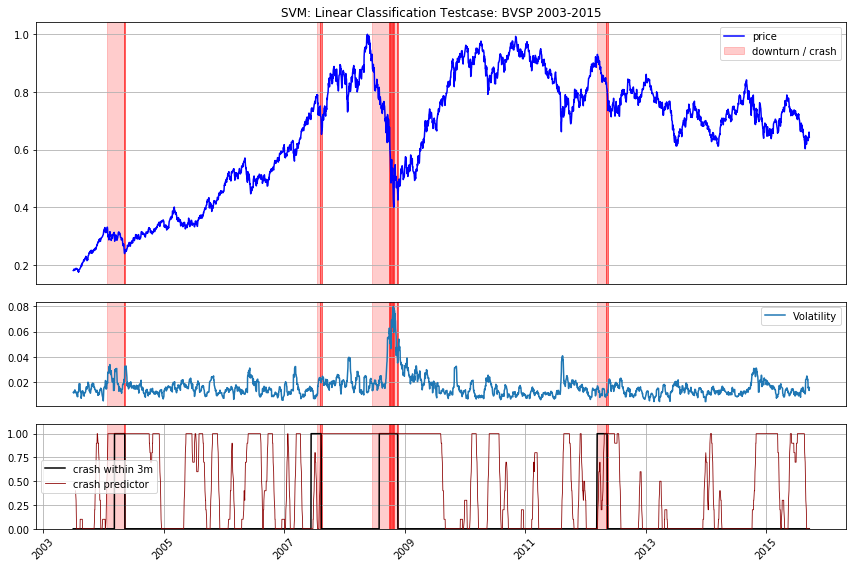

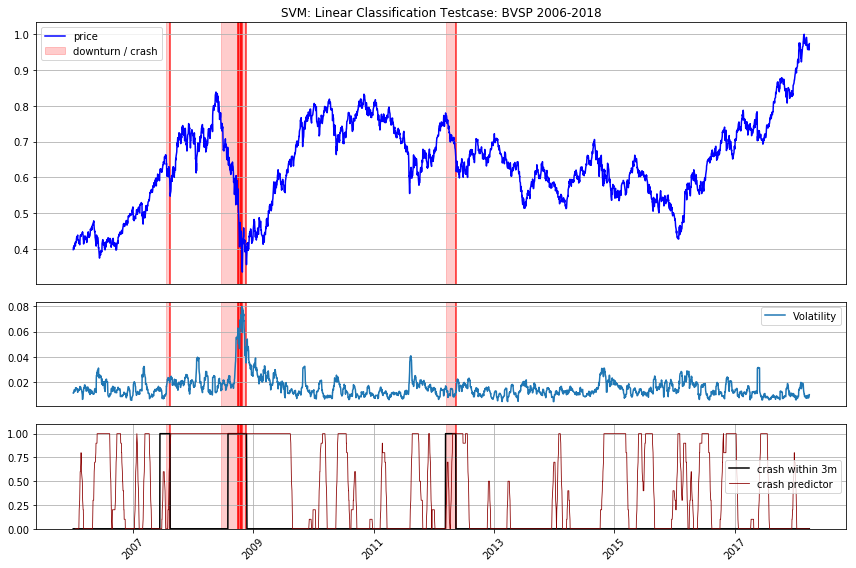

In [12]:
##### Linear SVM - plots for all test cases:
df_combined = [dfc.reindex(dfs.index) for dfc, dfs in zip(df_combined, dfs_xy)]
dfs_predict = []
for j in range(len(datasets)*2):
    i = round(j/2 + 0.1)
    k = round(j/2 - 0.1)
    if j % 2 == 0:
        df = df_combined[k].iloc[:n, :]
        df['y_pred'] = y_pred_bin_t_all[j]
        df['y'] = y_actual[j]
        dfs_predict.append(df)
    if j % 2 == 1:       
        df = df_combined[k].iloc[-n:, :]
        df['y_pred'] = y_pred_bin_t_all[j]
        df['y'] = y_actual[j]
        dfs_predict.append(df)
cr_ext = []
for c in crashes:
    cr_ext.append(c)
    cr_ext.append(c)
ds_name_ext = []
for ds_name in dataset_names:
    ds_name_ext.append(ds_name)
    ds_name_ext.append(ds_name)    
gs = gridspec.GridSpec(3, 1, height_ratios=[2.5, 1, 1]) 
for df, c, t in zip(dfs_predict, cr_ext, ds_name_ext):
    t1 = df.index[0]
    t2 = df.index[-1]
    plt.subplot(gs[0])
    down_st = list(filter(lambda x: x > t1 and x < t2, c['down_st']))
    crash_st = list(filter(lambda x: x > t1 and x < t2, c['crash_st']))
    crash_end = list(filter(lambda x: x > t1 and x < t2, c['crash_end']))
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    df_norm = df['price'][t1:t2] / df['price'][t1:t2].max()
    plt.plot(df_norm[t1:t2], color='blue') 
    plt.title(model_name + ' Testcase: ' + t + ' ' + str(df.index[0].year) + '-' \
              + str(df.index[-1].year))
    plt.legend(['price', 'downturn / crash'])
    plt.xticks([])
    plt.grid()     
    plt.subplot(gs[1])
    plt.plot(df.loc[t1:t2, 'vol'])
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['Volatility'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.xticks([])
    plt.subplot(gs[2])
    plt.plot(df['y'][t1:t2], color='black')
    plt.plot(df['y_pred'][t1:t2].rolling(10).mean(), color='darkred', linewidth=0.8)
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['crash within 3m', 'crash predictor'])
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.show()  

In [ ]:
########################### SVM Classifier nonlinear ########################### 
# define, train and test model:
model_name = 'SVM: Nonlinear Classification (RBF)'
clf = svm.SVC(C=1, kernel='rbf', class_weight='balanced')#'rbf: radial basis function

precision_tr = []
recall_tr = []
accuracy_tr = []
precision_t = []
recall_t = []
accuracy_t = []
y_pred_bin_t_all = []  #<- store all test predictions here
y_pred_bin_tr_all = []
y_actual = []
y_tr_actual = []
for train, test in zip(np_train, np_test):
    x_tr = train[:, 0:-1]
    y_tr = train[:, -1].astype(int)  #<- crash as response variable
    y_tr_actual.append(y_tr)
    x_t = test[:, 0:-1]
    y_t = test[:, -1].astype(int)
    y_actual.append(y_t)
    model = clf.fit(x_tr, y_tr)
    y_pred_bin_tr = model.predict(x_tr)
    y_pred_bin_tr_all.append(y_pred_bin_tr) 
    precision_tr.append(metrics.precision_score(y_tr, y_pred_bin_tr))
    recall_tr.append(metrics.recall_score(y_tr, y_pred_bin_tr))
    accuracy_tr.append(metrics.accuracy_score(y_tr, y_pred_bin_tr))
    y_pred_bin_t = model.predict(x_t)
    y_pred_bin_t_all.append(y_pred_bin_t)  #<- list of test predictions for plots
    precision_t.append(metrics.precision_score(y_t, y_pred_bin_t))
    recall_t.append(metrics.recall_score(y_t, y_pred_bin_t))
    accuracy_t.append(metrics.accuracy_score(y_t, y_pred_bin_t))

avg_pr_tr = sum(precision_tr) / len(precision_tr)
avg_re_tr = sum(recall_tr) / len(recall_tr)
avg_ac_tr = sum(accuracy_tr) / len(accuracy_tr)
avg_pr_t = sum(precision_t) / len(precision_t)
avg_re_t = sum(recall_t) / len(recall_t)
avg_ac_t = sum(accuracy_t) / len(accuracy_t)

# calculate precision, recall, accuracy for comparable random model
rnd_y_tr_pos = sum(sum(y_pred_bin_tr_all)) / (len(y_pred_bin_tr_all[0])*len(y_pred_bin_tr_all))
y_tr_pos = sum(sum(y_tr_actual)) / (len(y_tr_actual[0])*len(y_tr_actual))
rnd_TP = rnd_y_tr_pos * y_tr_pos
rnd_FP = rnd_y_tr_pos * (1 - y_tr_pos)
rnd_TN = (1-rnd_y_tr_pos) * (1 - y_tr_pos)
rnd_FN = (1-rnd_y_tr_pos) * y_tr_pos
rnd_pr_tr = rnd_TP / (rnd_TP+rnd_FP)
rnd_re_tr = rnd_TP / (rnd_TP+rnd_FN)
rnd_ac_tr = rnd_TP + rnd_TN
rnd_y_t_pos = sum(sum(y_pred_bin_t_all)) / (len(y_pred_bin_t_all[0])*len(y_pred_bin_t_all))
y_t_pos = sum(sum(y_actual)) / (len(y_actual[0])*len(y_actual))
rnd_TP = rnd_y_t_pos * y_t_pos
rnd_FP = rnd_y_t_pos * (1 - y_t_pos)
rnd_TN = (1-rnd_y_t_pos) * (1 - y_t_pos)
rnd_FN = (1-rnd_y_t_pos) * y_t_pos
rnd_pr_t = rnd_TP / (rnd_TP+rnd_FP)
rnd_re_t = rnd_TP / (rnd_TP+rnd_FN)
rnd_ac_t = rnd_TP + rnd_TN

# score: square of loss, multiplied by wtd over precision, recall, accuracy
wtd_pr = 0.325
wtd_re = 0.375
wtd_ac = 0.3
pr_tr = (avg_pr_tr - rnd_pr_tr) / (1 - rnd_pr_tr)
re_tr = (avg_re_tr - rnd_re_tr) / (1 - rnd_re_tr)
ac_tr = (avg_ac_tr - rnd_ac_tr) / (1 - rnd_ac_tr)
score_tr = (1-(wtd_pr*(1-pr_tr)**2+wtd_re*(1-re_tr)**2+wtd_ac*(1-ac_tr)**2))*100
pr_t = (avg_pr_t - rnd_pr_t) / (1 - rnd_pr_t)
re_t = (avg_re_t - rnd_re_t) / (1 - rnd_re_t)
ac_t = (avg_ac_t - rnd_ac_t) / (1 - rnd_ac_t)
score_t = (1-(wtd_pr*(1-pr_t)**2+wtd_re*(1-re_t)**2+wtd_ac*(1-ac_t)**2))*100

print('Results ' + model_name + ':')
print('Number of features: ' + str(dfs_xy[0].shape[1]-1) + '; number of rows: ' \
      + str(np_xy.shape[0]))
print('Positive train cases actual:        '+ str(round(y_tr_pos, 2)))
print('Positive train cases predicted:     '+ str(round(rnd_y_tr_pos, 2)))
print('Avg precision train (model/random): '+ str(round(avg_pr_tr, 2))+' / '+str(round(rnd_pr_tr, 2)))
print('Avg recall train (model/random):    '+ str(round(avg_re_tr, 2))+' / '+str(round(rnd_re_tr, 2)))
print('Avg accuracy train (model/random):  '+ str(round(avg_ac_tr, 2))+' / '+str(round(rnd_ac_tr, 2)))
print('Score train:                        '+ str(round(score_tr)))
print('Positive test cases actual:         '+ str(round(y_t_pos, 2)))
print('Positive test cases predicted:      '+ str(round(rnd_y_t_pos, 2)))
print('Avg precision test (model/random):  '+ str(round(avg_pr_t, 2))+' / '+str(round(rnd_pr_t, 2)))
print('Avg recall test (model/random):     '+ str(round(avg_re_t, 2))+' / '+str(round(rnd_re_t, 2)))
print('Avg accuracy test (model/random):   '+ str(round(avg_ac_t, 2))+' / '+str(round(rnd_ac_t, 2)))
print('Score test:                         '+ str(round(score_t)))

In [ ]:
##### Nonlinear SVM - plots for all test cases:
df_combined = [dfc.reindex(dfs.index) for dfc, dfs in zip(df_combined, dfs_xy)]
dfs_predict = []
for j in range(len(datasets)*2):
    i = round(j/2 + 0.1)
    k = round(j/2 - 0.1)
    if j % 2 == 0:
        df = df_combined[k].iloc[:n, :]
        df['y_pred'] = y_pred_bin_t_all[j]
        df['y'] = y_actual[j]
        dfs_predict.append(df)
    if j % 2 == 1:       
        df = df_combined[k].iloc[-n:, :]
        df['y_pred'] = y_pred_bin_t_all[j]
        df['y'] = y_actual[j]
        dfs_predict.append(df)
cr_ext = []
for c in crashes:
    cr_ext.append(c)
    cr_ext.append(c)
ds_name_ext = []
for ds_name in dataset_names:
    ds_name_ext.append(ds_name)
    ds_name_ext.append(ds_name)    
gs = gridspec.GridSpec(3, 1, height_ratios=[2.5, 1, 1]) 
for df, c, t in zip(dfs_predict, cr_ext, ds_name_ext):
    t1 = df.index[0]
    t2 = df.index[-1]
    plt.subplot(gs[0])
    down_st = list(filter(lambda x: x > t1 and x < t2, c['down_st']))
    crash_st = list(filter(lambda x: x > t1 and x < t2, c['crash_st']))
    crash_end = list(filter(lambda x: x > t1 and x < t2, c['crash_end']))
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    df_norm = df['price'][t1:t2] / df['price'][t1:t2].max()
    plt.plot(df_norm[t1:t2], color='blue') 
    plt.title(model_name + ' Testcase: ' + t + ' ' + str(df.index[0].year) + '-' \
              + str(df.index[-1].year))
    plt.legend(['price', 'downturn / crash'])
    plt.xticks([])
    plt.grid()     
    plt.subplot(gs[1])
    plt.plot(df.loc[t1:t2, 'vol'])
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['Volatility'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.xticks([])
    plt.subplot(gs[2])
    plt.plot(df['y'][t1:t2], color='black')
    plt.plot(df['y_pred'][t1:t2].rolling(10).mean(), color='darkred', linewidth=0.8)
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['crash within 3m', 'crash predictor'])
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.show()  

In [13]:
########################### Decision Tree ########################### 
model_name = 'Decision Tree'
clf = tree.DecisionTreeClassifier()

precision_tr = []
recall_tr = []
accuracy_tr = []
precision_t = []
recall_t = []
accuracy_t = []
y_pred_bin_t_all = []  #<- store all test predictions here
y_pred_bin_tr_all = []
y_actual = []
y_tr_actual = []
for train, test in zip(np_train, np_test):
    x_tr = train[:, 0:-1]
    y_tr = train[:, -1].astype(int)  #<- crash as response variable
    y_tr_actual.append(y_tr)
    x_t = test[:, 0:-1]
    y_t = test[:, -1].astype(int)
    y_actual.append(y_t)
    model = clf.fit(x_tr, y_tr)
    y_pred_bin_tr = model.predict(x_tr)
    y_pred_bin_tr_all.append(y_pred_bin_tr) 
    precision_tr.append(metrics.precision_score(y_tr, y_pred_bin_tr))
    recall_tr.append(metrics.recall_score(y_tr, y_pred_bin_tr))
    accuracy_tr.append(metrics.accuracy_score(y_tr, y_pred_bin_tr))
    y_pred_bin_t = model.predict(x_t)
    y_pred_bin_t_all.append(y_pred_bin_t)  #<- list of test predictions for plots
    precision_t.append(metrics.precision_score(y_t, y_pred_bin_t))
    recall_t.append(metrics.recall_score(y_t, y_pred_bin_t))
    accuracy_t.append(metrics.accuracy_score(y_t, y_pred_bin_t))

avg_pr_tr = sum(precision_tr) / len(precision_tr)
avg_re_tr = sum(recall_tr) / len(recall_tr)
avg_ac_tr = sum(accuracy_tr) / len(accuracy_tr)
avg_pr_t = sum(precision_t) / len(precision_t)
avg_re_t = sum(recall_t) / len(recall_t)
avg_ac_t = sum(accuracy_t) / len(accuracy_t)

# calculate precision, recall, accuracy for comparable random model
rnd_y_tr_pos = sum(sum(y_pred_bin_tr_all)) / (len(y_pred_bin_tr_all[0])*len(y_pred_bin_tr_all))
y_tr_pos = sum(sum(y_tr_actual)) / (len(y_tr_actual[0])*len(y_tr_actual))
rnd_TP = rnd_y_tr_pos * y_tr_pos
rnd_FP = rnd_y_tr_pos * (1 - y_tr_pos)
rnd_TN = (1-rnd_y_tr_pos) * (1 - y_tr_pos)
rnd_FN = (1-rnd_y_tr_pos) * y_tr_pos
rnd_pr_tr = rnd_TP / (rnd_TP+rnd_FP)
rnd_re_tr = rnd_TP / (rnd_TP+rnd_FN)
rnd_ac_tr = rnd_TP + rnd_TN
rnd_y_t_pos = sum(sum(y_pred_bin_t_all)) / (len(y_pred_bin_t_all[0])*len(y_pred_bin_t_all))
y_t_pos = sum(sum(y_actual)) / (len(y_actual[0])*len(y_actual))
rnd_TP = rnd_y_t_pos * y_t_pos
rnd_FP = rnd_y_t_pos * (1 - y_t_pos)
rnd_TN = (1-rnd_y_t_pos) * (1 - y_t_pos)
rnd_FN = (1-rnd_y_t_pos) * y_t_pos
rnd_pr_t = rnd_TP / (rnd_TP+rnd_FP)
rnd_re_t = rnd_TP / (rnd_TP+rnd_FN)
rnd_ac_t = rnd_TP + rnd_TN

# score: square of loss, multiplied by wtd over precision, recall, accuracy
wtd_pr = 0.325
wtd_re = 0.375
wtd_ac = 0.3
pr_tr = (avg_pr_tr - rnd_pr_tr) / (1 - rnd_pr_tr)
re_tr = (avg_re_tr - rnd_re_tr) / (1 - rnd_re_tr)
ac_tr = (avg_ac_tr - rnd_ac_tr) / (1 - rnd_ac_tr)
score_tr = (1-(wtd_pr*(1-pr_tr)**2+wtd_re*(1-re_tr)**2+wtd_ac*(1-ac_tr)**2))*100
pr_t = (avg_pr_t - rnd_pr_t) / (1 - rnd_pr_t)
re_t = (avg_re_t - rnd_re_t) / (1 - rnd_re_t)
ac_t = (avg_ac_t - rnd_ac_t) / (1 - rnd_ac_t)
score_t = (1-(wtd_pr*(1-pr_t)**2+wtd_re*(1-re_t)**2+wtd_ac*(1-ac_t)**2))*100

print('Results ' + model_name + ':')
print('Number of features: ' + str(dfs_xy[0].shape[1]-1) + '; number of rows: ' \
      + str(np_xy.shape[0]))
print('Positive train cases actual:        '+ str(round(y_tr_pos, 2)))
print('Positive train cases predicted:     '+ str(round(rnd_y_tr_pos, 2)))
print('Avg precision train (model/random): '+ str(round(avg_pr_tr, 2))+' / '+str(round(rnd_pr_tr, 2)))
print('Avg recall train (model/random):    '+ str(round(avg_re_tr, 2))+' / '+str(round(rnd_re_tr, 2)))
print('Avg accuracy train (model/random):  '+ str(round(avg_ac_tr, 2))+' / '+str(round(rnd_ac_tr, 2)))
print('Score train:                        '+ str(round(score_tr)))
print('Positive test cases actual:         '+ str(round(y_t_pos, 2)))
print('Positive test cases predicted:      '+ str(round(rnd_y_t_pos, 2)))
print('Avg precision test (model/random):  '+ str(round(avg_pr_t, 2))+' / '+str(round(rnd_pr_t, 2)))
print('Avg recall test (model/random):     '+ str(round(avg_re_t, 2))+' / '+str(round(rnd_re_t, 2)))
print('Avg accuracy test (model/random):   '+ str(round(avg_ac_t, 2))+' / '+str(round(rnd_ac_t, 2)))
print('Score test:                         '+ str(round(score_t)))  

Results Decision Tree:
Number of features: 504; number of rows: 46327
Positive train cases actual:        0.05
Positive train cases predicted:     0.05
Avg precision train (model/random): 1.0 / 0.05
Avg recall train (model/random):    1.0 / 0.05
Avg accuracy train (model/random):  1.0 / 0.91
Score train:                        100.0
Positive test cases actual:         0.06
Positive test cases predicted:      0.07
Avg precision test (model/random):  0.14 / 0.06
Avg recall test (model/random):     0.13 / 0.07
Avg accuracy test (model/random):   0.89 / 0.88
Score test:                         15.0


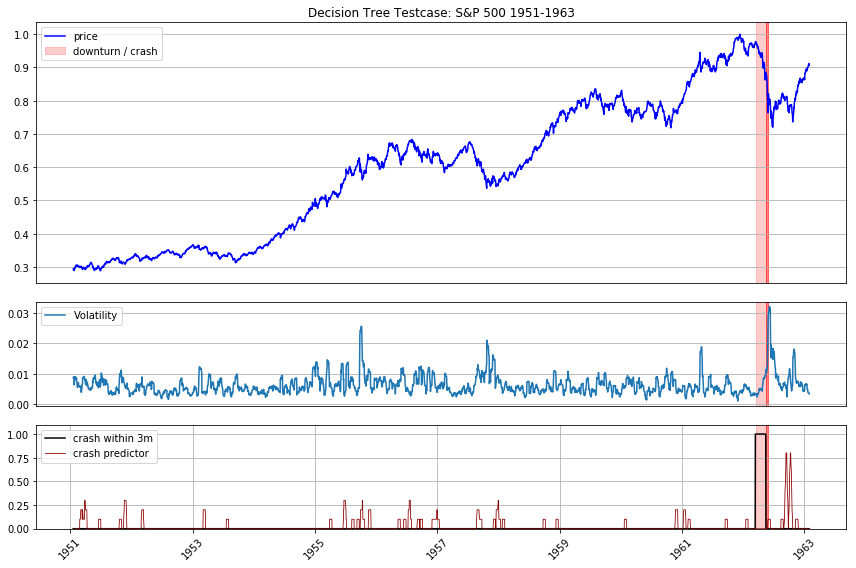

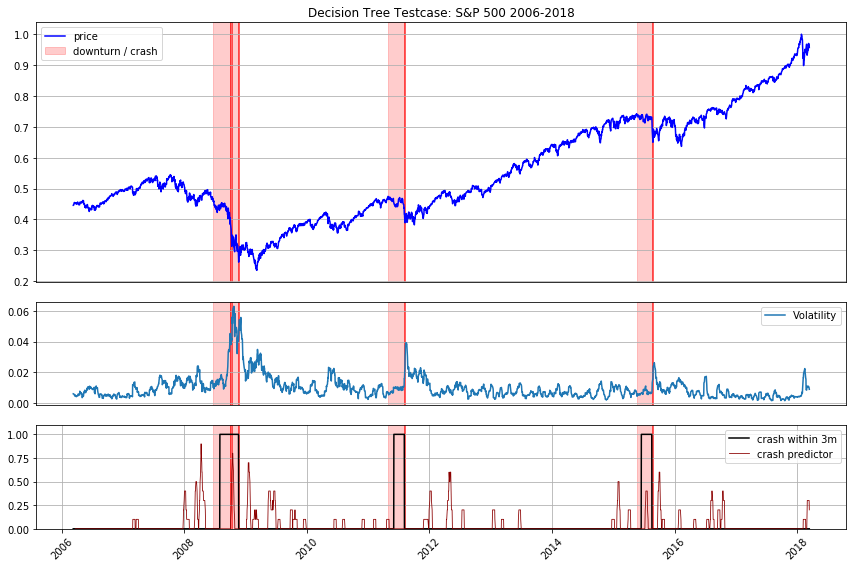

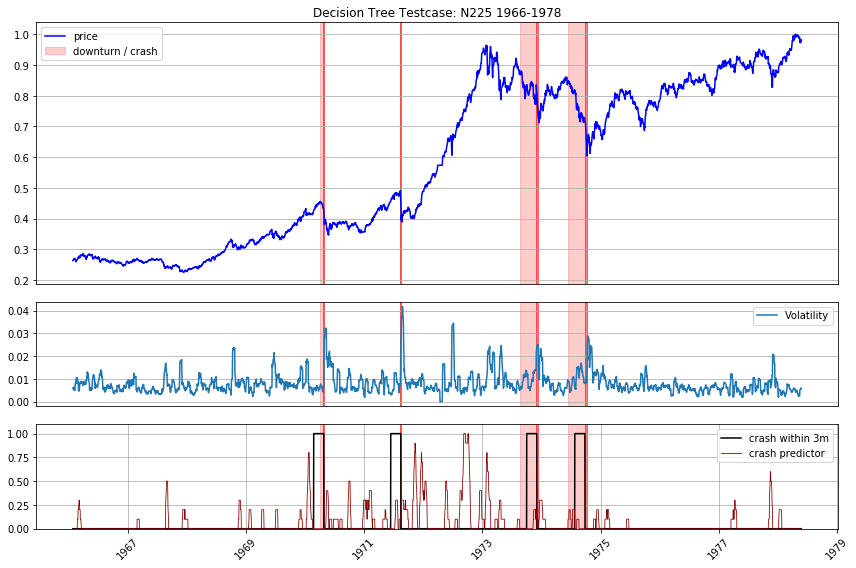

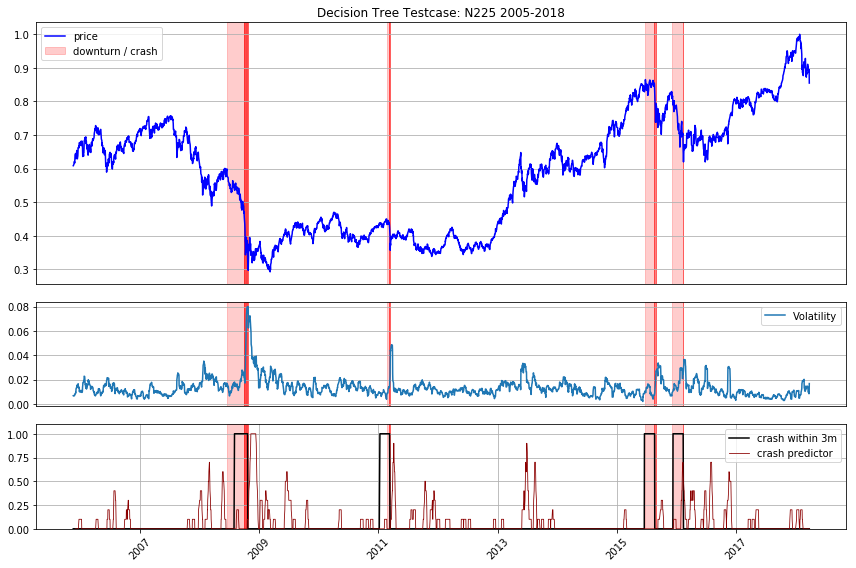

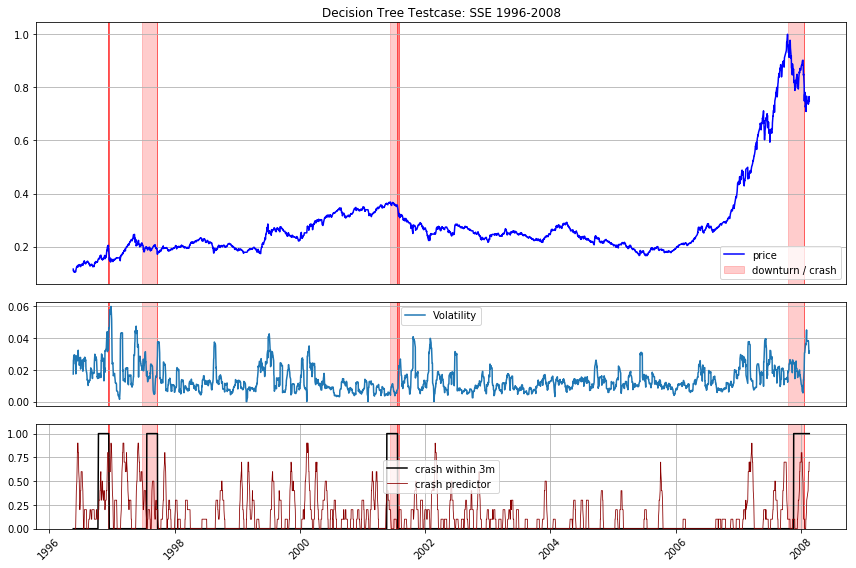

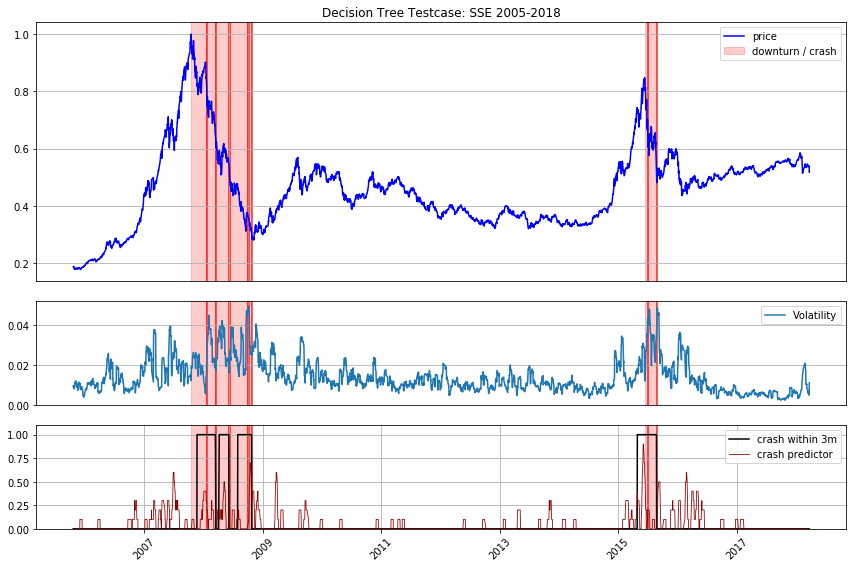

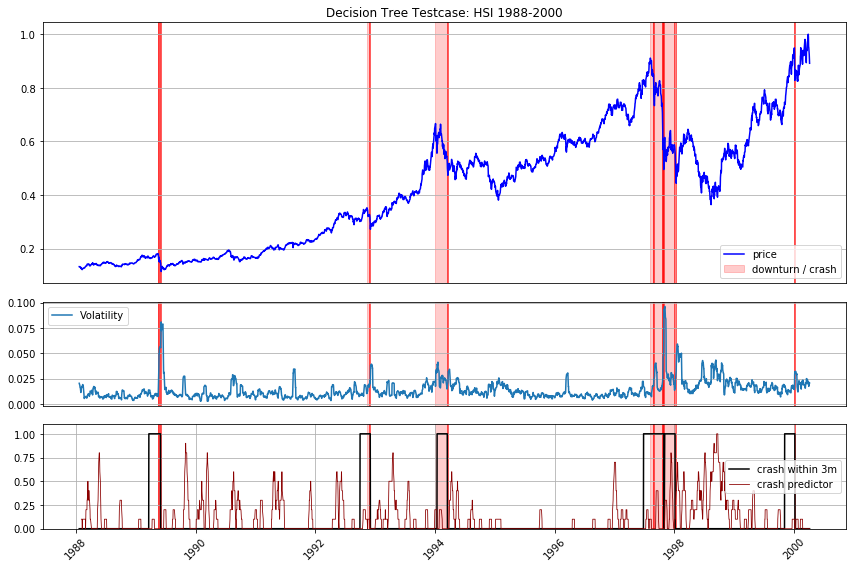

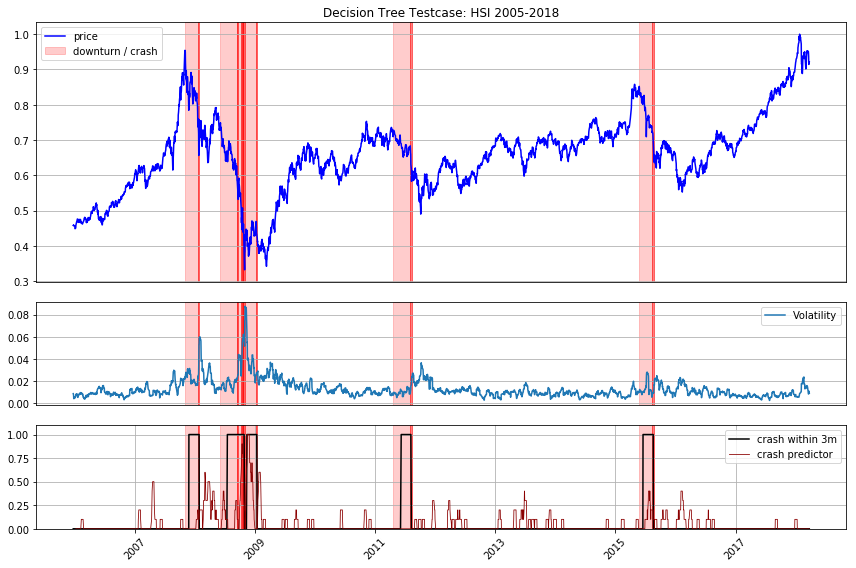

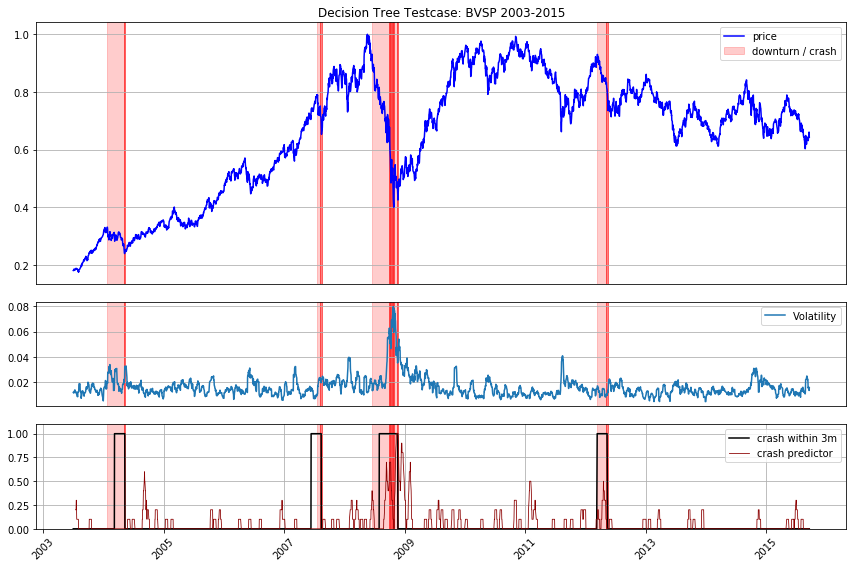

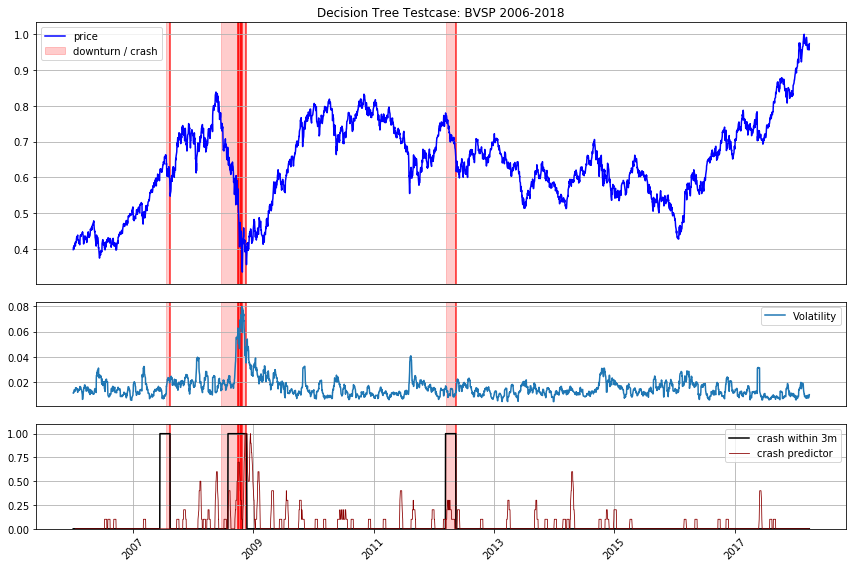

In [14]:
##### Decision Tree - plots for all test cases:
df_combined = [dfc.reindex(dfs.index) for dfc, dfs in zip(df_combined, dfs_xy)]
dfs_predict = []
for j in range(len(datasets)*2):
    i = round(j/2 + 0.1)
    k = round(j/2 - 0.1)
    if j % 2 == 0:
        df = df_combined[k].iloc[:n, :]
        df['y_pred'] = y_pred_bin_t_all[j]
        df['y'] = y_actual[j]
        dfs_predict.append(df)
    if j % 2 == 1:       
        df = df_combined[k].iloc[-n:, :]
        df['y_pred'] = y_pred_bin_t_all[j]
        df['y'] = y_actual[j]
        dfs_predict.append(df)
cr_ext = []
for c in crashes:
    cr_ext.append(c)
    cr_ext.append(c)
ds_name_ext = []
for ds_name in dataset_names:
    ds_name_ext.append(ds_name)
    ds_name_ext.append(ds_name)    
gs = gridspec.GridSpec(3, 1, height_ratios=[2.5, 1, 1]) 
for df, c, t in zip(dfs_predict, cr_ext, ds_name_ext):
    t1 = df.index[0]
    t2 = df.index[-1]
    plt.subplot(gs[0])
    down_st = list(filter(lambda x: x > t1 and x < t2, c['down_st']))
    crash_st = list(filter(lambda x: x > t1 and x < t2, c['crash_st']))
    crash_end = list(filter(lambda x: x > t1 and x < t2, c['crash_end']))
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    df_norm = df['price'][t1:t2] / df['price'][t1:t2].max()
    plt.plot(df_norm[t1:t2], color='blue') 
    plt.title(model_name + ' Testcase: ' + t + ' ' + str(df.index[0].year) + '-' \
              + str(df.index[-1].year))
    plt.legend(['price', 'downturn / crash'])
    plt.xticks([])
    plt.grid()     
    plt.subplot(gs[1])
    plt.plot(df.loc[t1:t2, 'vol'])
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['Volatility'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.xticks([])
    plt.subplot(gs[2])
    plt.plot(df['y'][t1:t2], color='black')
    plt.plot(df['y_pred'][t1:t2].rolling(10).mean(), color='darkred', linewidth=0.8)
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['crash within 3m', 'crash predictor'])
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.show()  